In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.inference                      import elbo as elbo_py
from mrashpen.inference                      import coordinate_descent_step as cd_step

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = obj[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.elbo_path[-1], obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def linreg_summary_df_noelbo(sigma2, objs, methods):
    data     = [[strue * strue, '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def get_elbos(X, y, b, w, sk, s2):
    elbo1 = cd_step.elbo(X, y, sk, b, w, s2)

    dj     = np.sum(np.square(X), axis = 0)
    r      = y - np.mean(y) - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    elbo2  = elbo_py.scalemix(X, y, sk, b, w, s2,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    return elbo1, elbo2

In [2]:
n = 200
p = 2000
p_causal = 10
pve = 0.95
rho = 0.95
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [3]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)

'''
mr.ash.pen
'''
# plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, is_prior_scaled = True,
#                 debug = False, display_progress = False, calculate_elbo = True, maxiter = 2000)
# plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = s2init)
#plr_lbfgs = lbfgsfit.method_fixseq_simple(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)
plr_lbfgs = lbfgsfit.method_init_gb(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)

R[write to console]: Loading required package: Matrix



[0. 0. 0. ... 0. 0. 0.]
mr.ash.pen terminated at iteration 2028.


In [4]:
'''
mr.ash.pen (EM)
'''
#plr_eb = ebfit(X, y, sk, wk, binit = lasso_b, s2init = 1, maxiter = 200, qb_maxiter = 100)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = 1)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

Mr.ASH terminated at iteration 348.
Mr.ASH terminated at iteration 192.


In [5]:
lasso_a0_2, lasso_b_2, _ = R_lasso.fit(X, y)
s2init_2 = np.var(y - np.dot(X, lasso_b_2) - lasso_a0_2)

lasso_a0_2, lasso_b_2, _ = R_lasso.fit(X, y)
s2init_2 = np.var(y - np.dot(X, lasso_b_2) - lasso_a0_2)

In [6]:
lasso_b[np.abs(lasso_b) > 0.01]

array([-0.08443814, -0.01247918,  0.06952257,  1.15245504, -1.08242168,
       -0.04132255, -1.10129228, -0.03333598, -0.97315299, -0.0530984 ,
       -0.04173867, -0.02467944,  0.03593737, -0.02028762, -0.04550787,
        0.05754109,  0.01398249, -0.31125017,  1.32154164,  0.66813013,
       -0.03482808,  0.0314953 , -0.0769049 , -0.0476398 ,  0.0149215 ,
       -0.03843524,  0.04813299])

In [7]:
lasso_b_2[np.abs(lasso_b) > 0.01]

array([-0.08761493, -0.0163246 ,  0.07644898,  1.15835736, -1.08406873,
       -0.04078622, -1.1042094 , -0.03896603, -0.97760612, -0.05273304,
       -0.04454234, -0.02673314,  0.04426397, -0.02479306, -0.0484571 ,
        0.0611751 ,  0.01735821, -0.31498192,  1.32738851,  0.67540669,
       -0.039448  ,  0.03806969, -0.07876627, -0.05292481,  0.02036465,
       -0.04081539,  0.05424247])

In [8]:
s2init

0.05067581241863296

In [9]:
s2init_2

0.04849058161621035

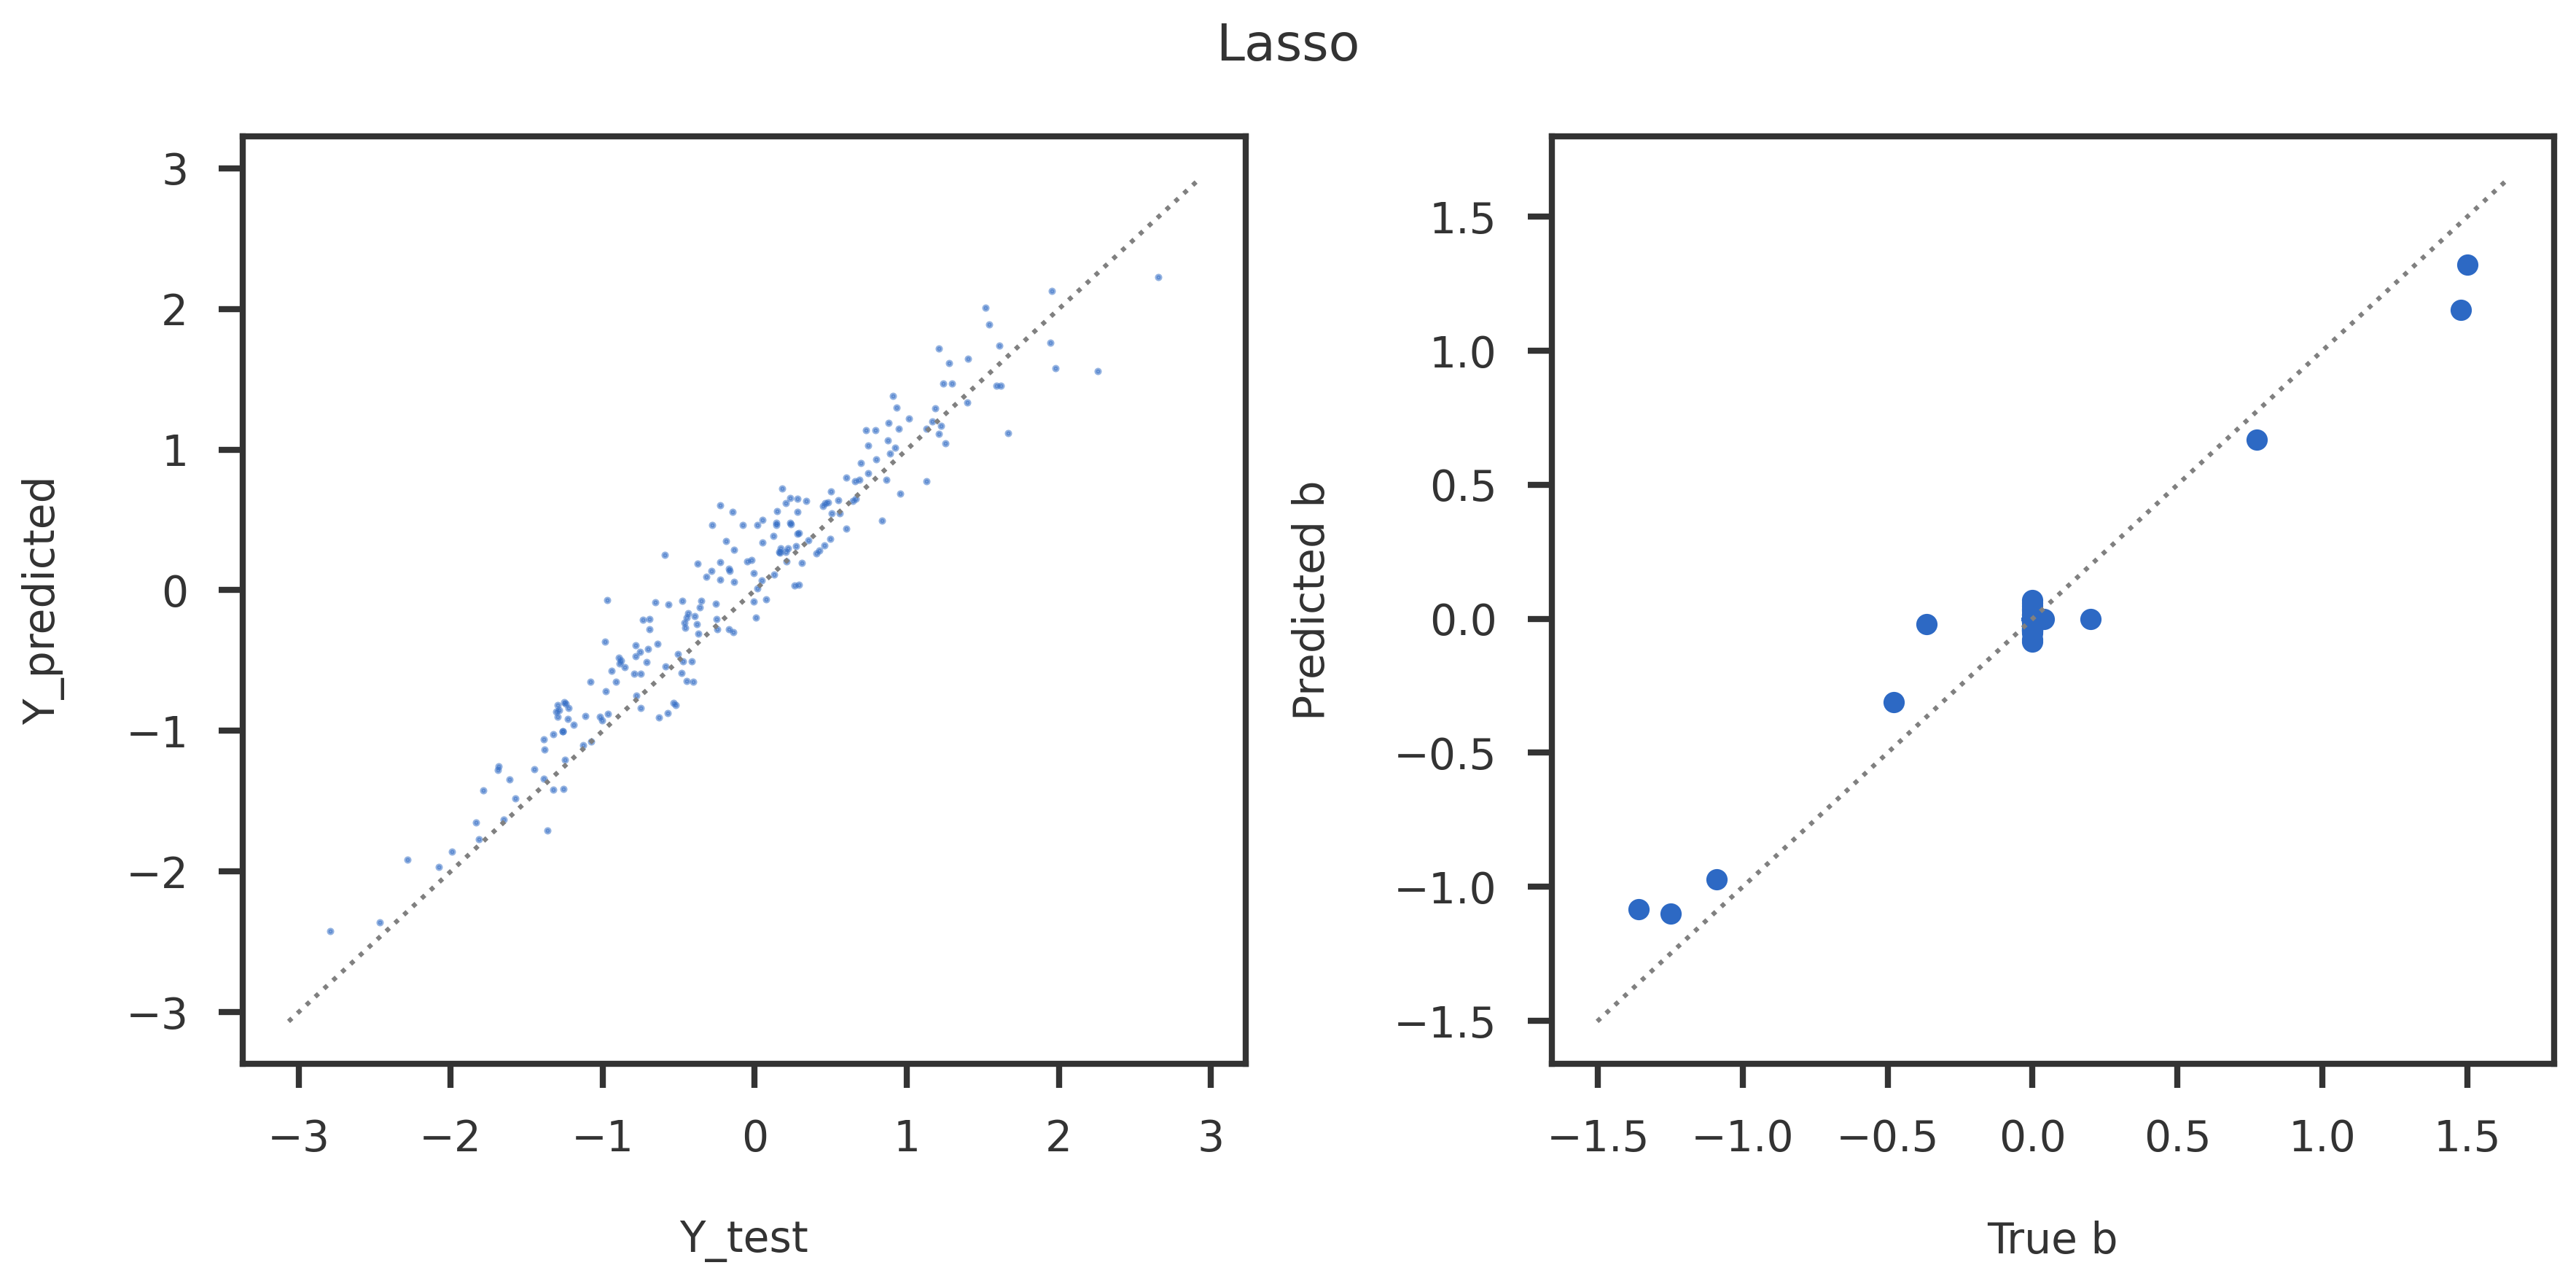

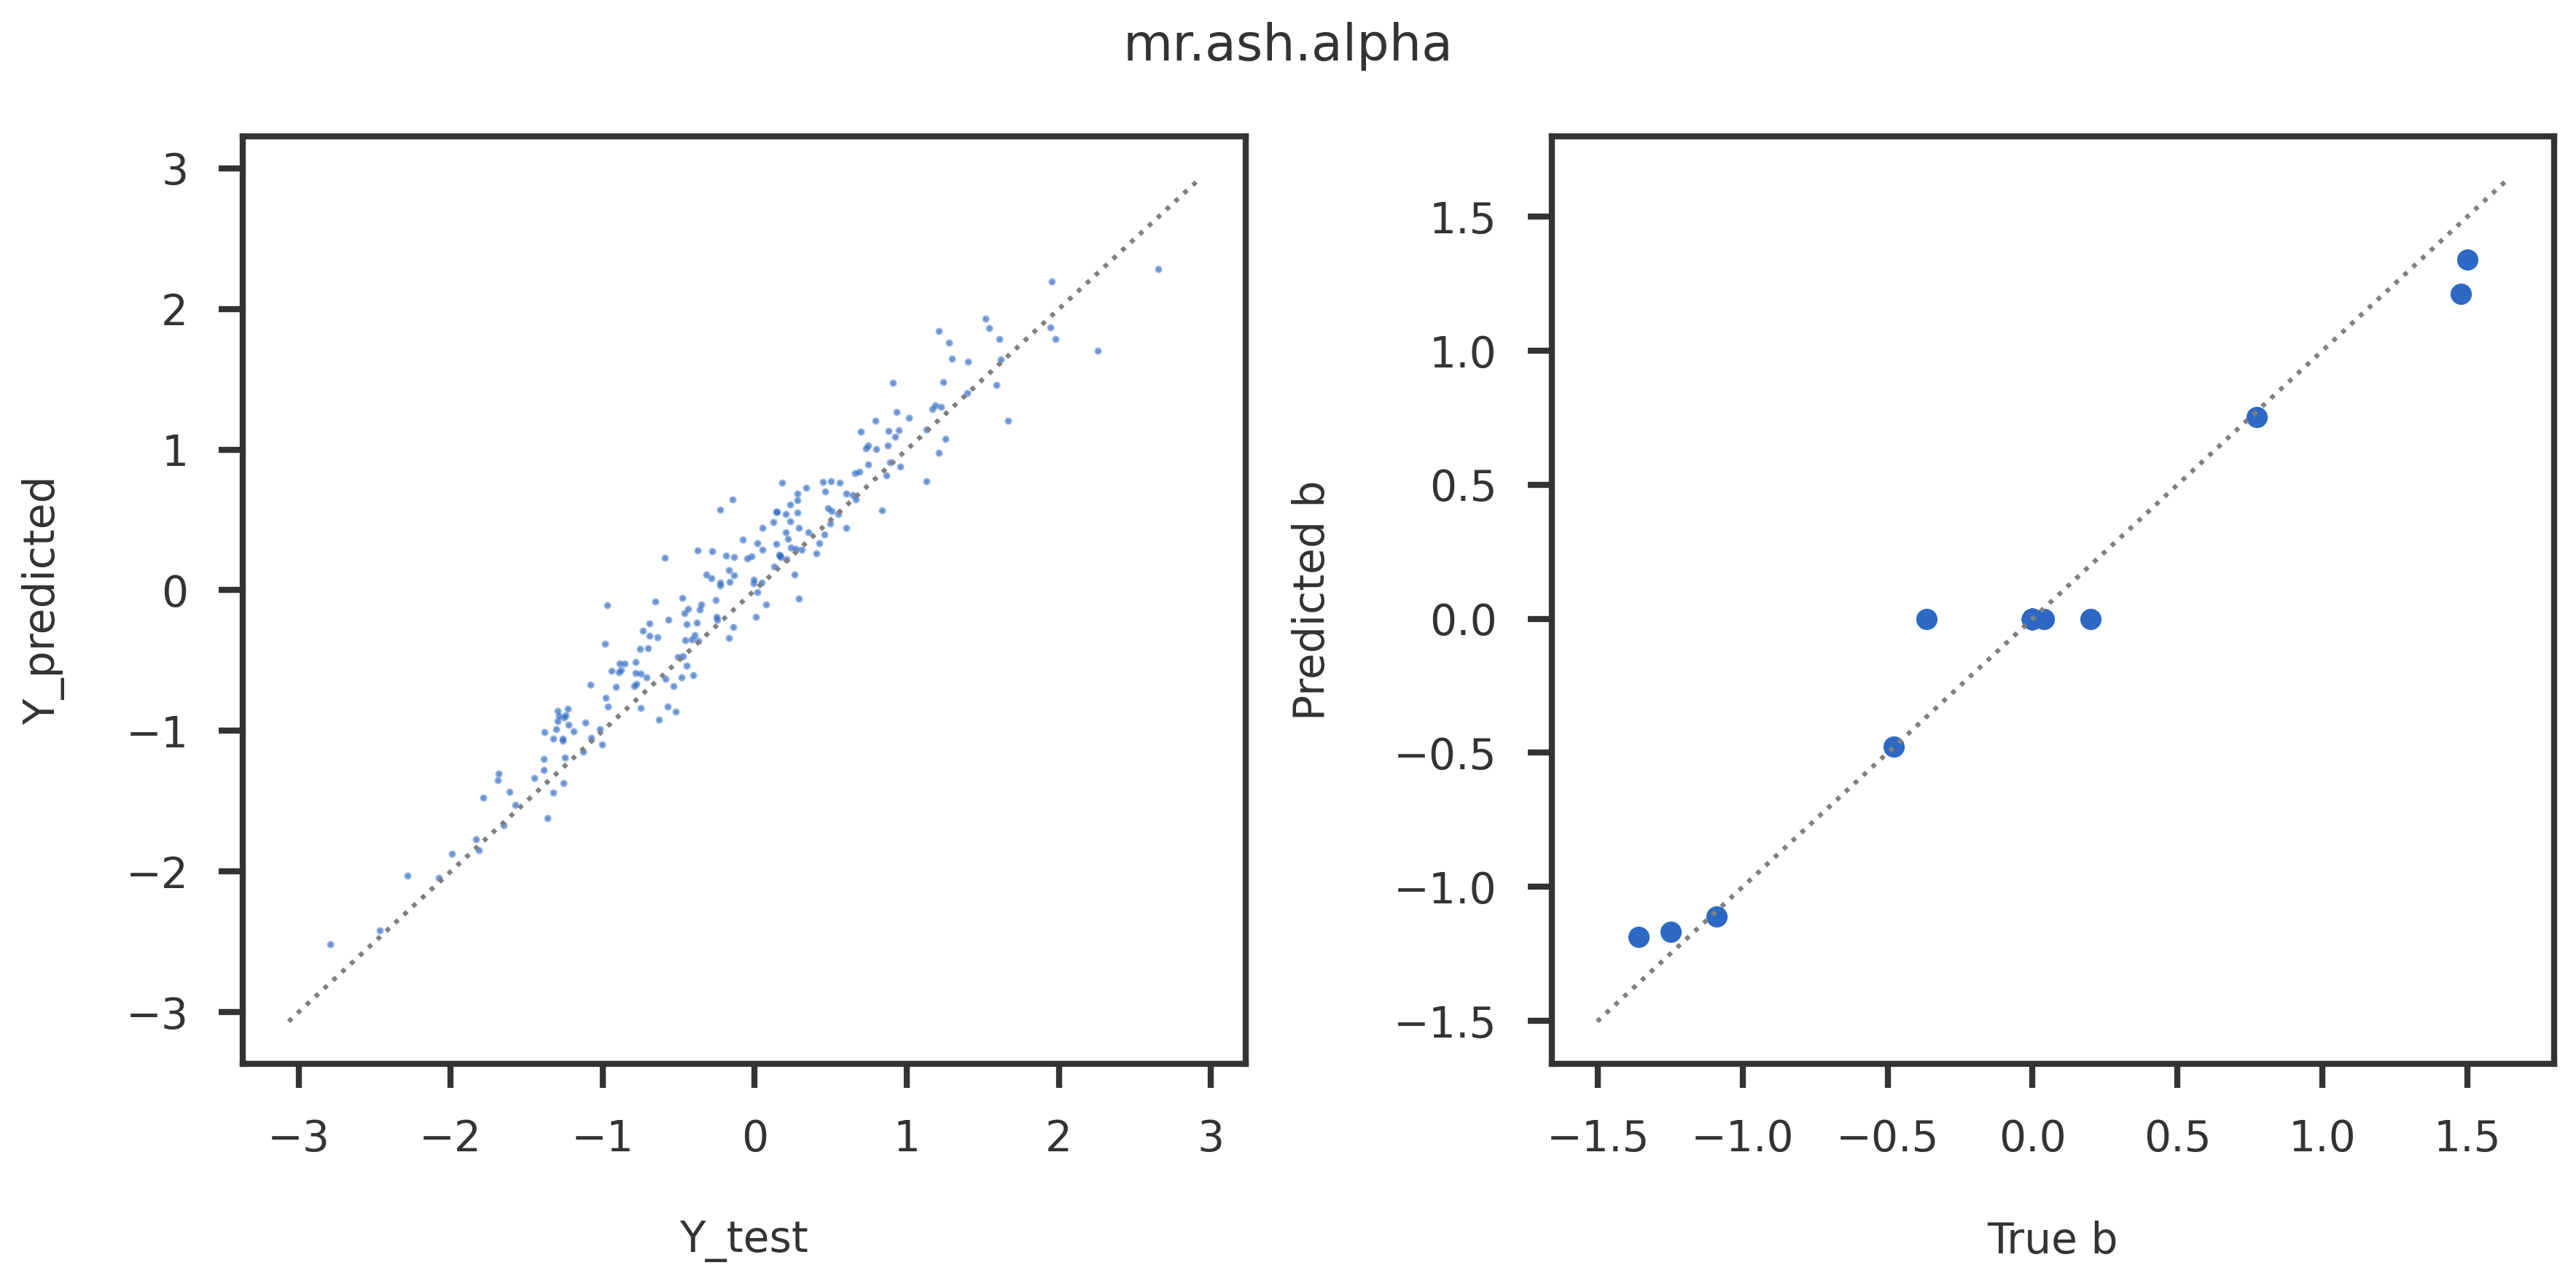

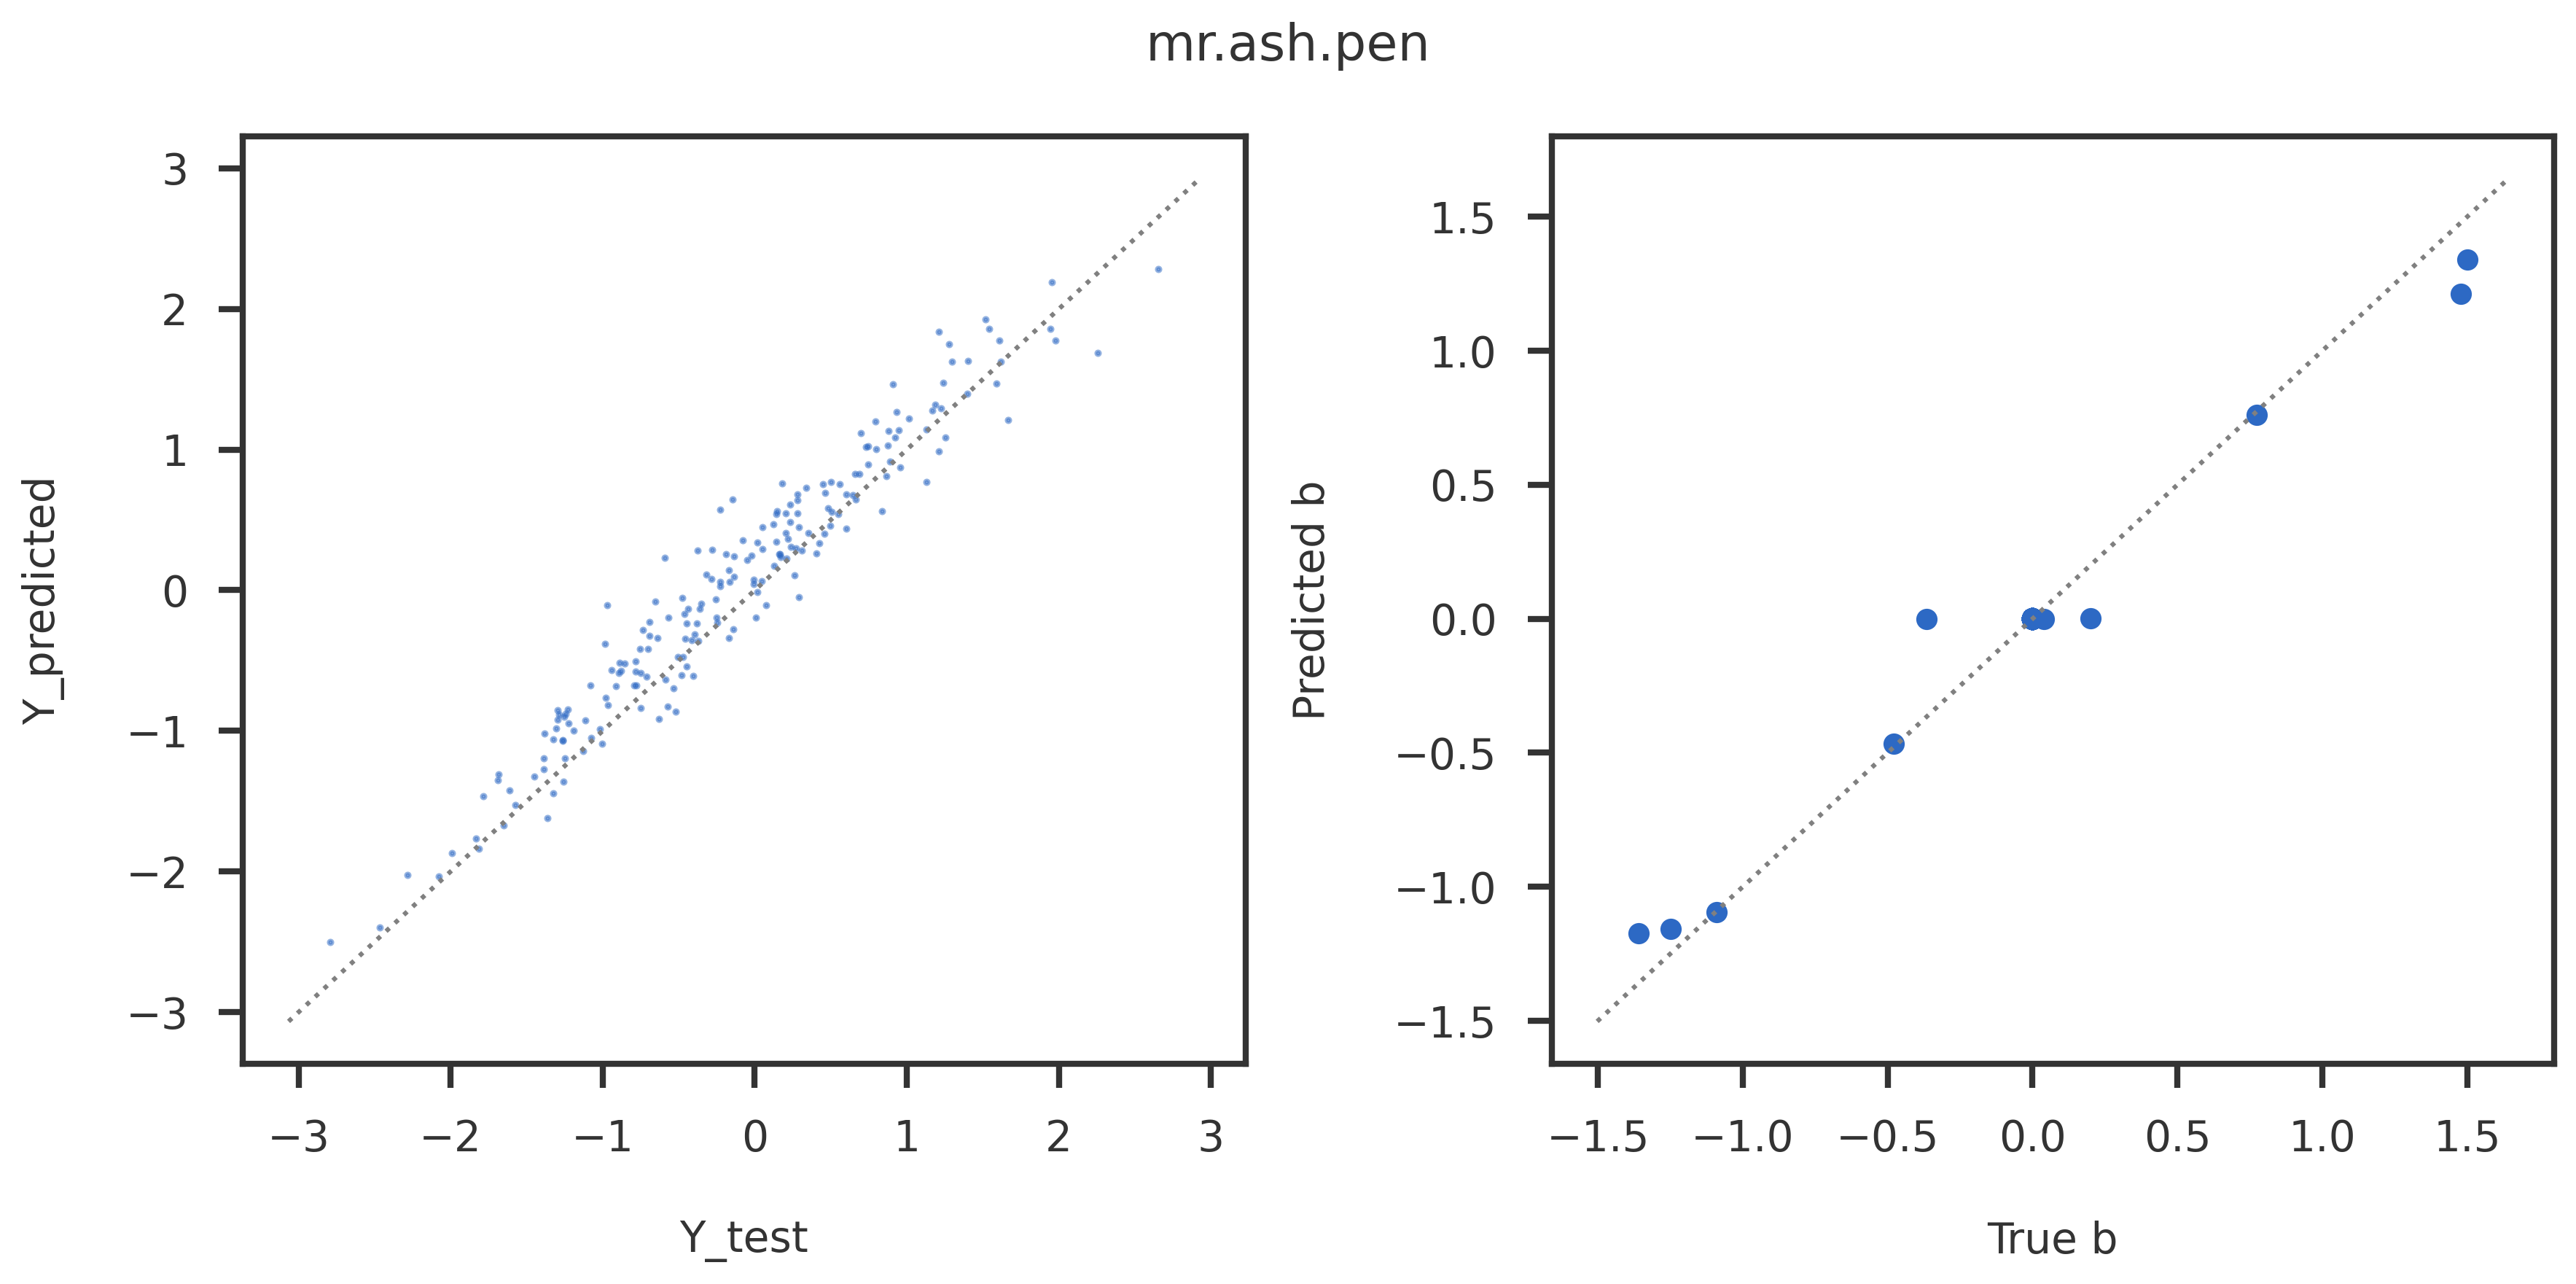

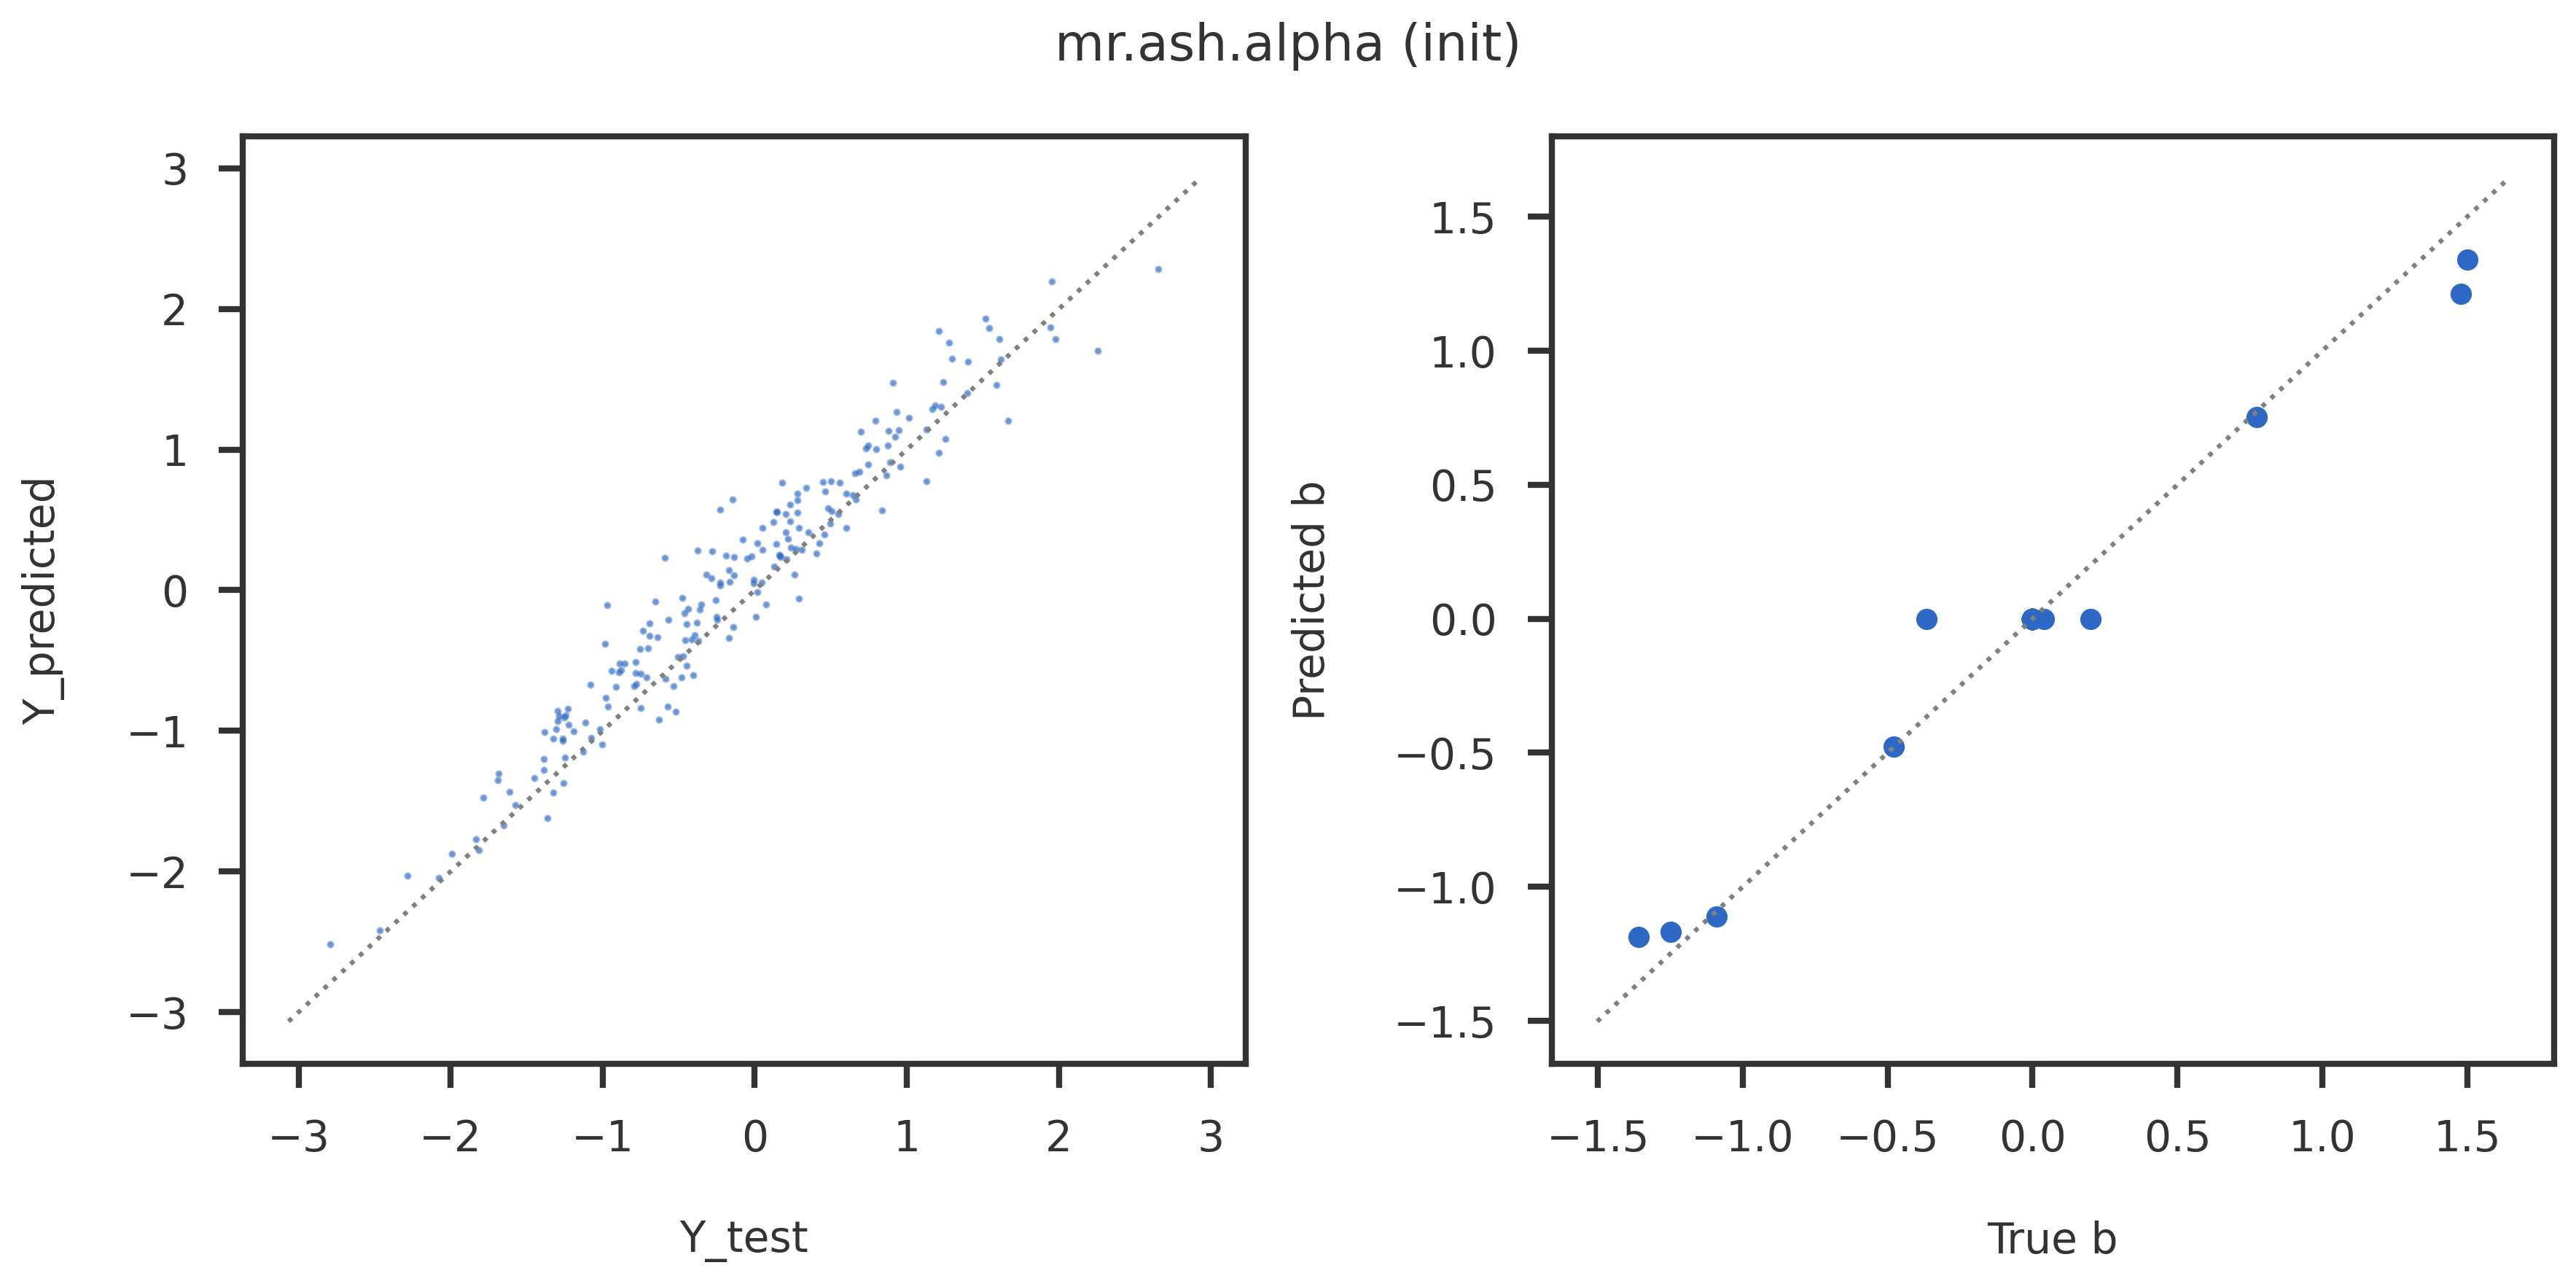

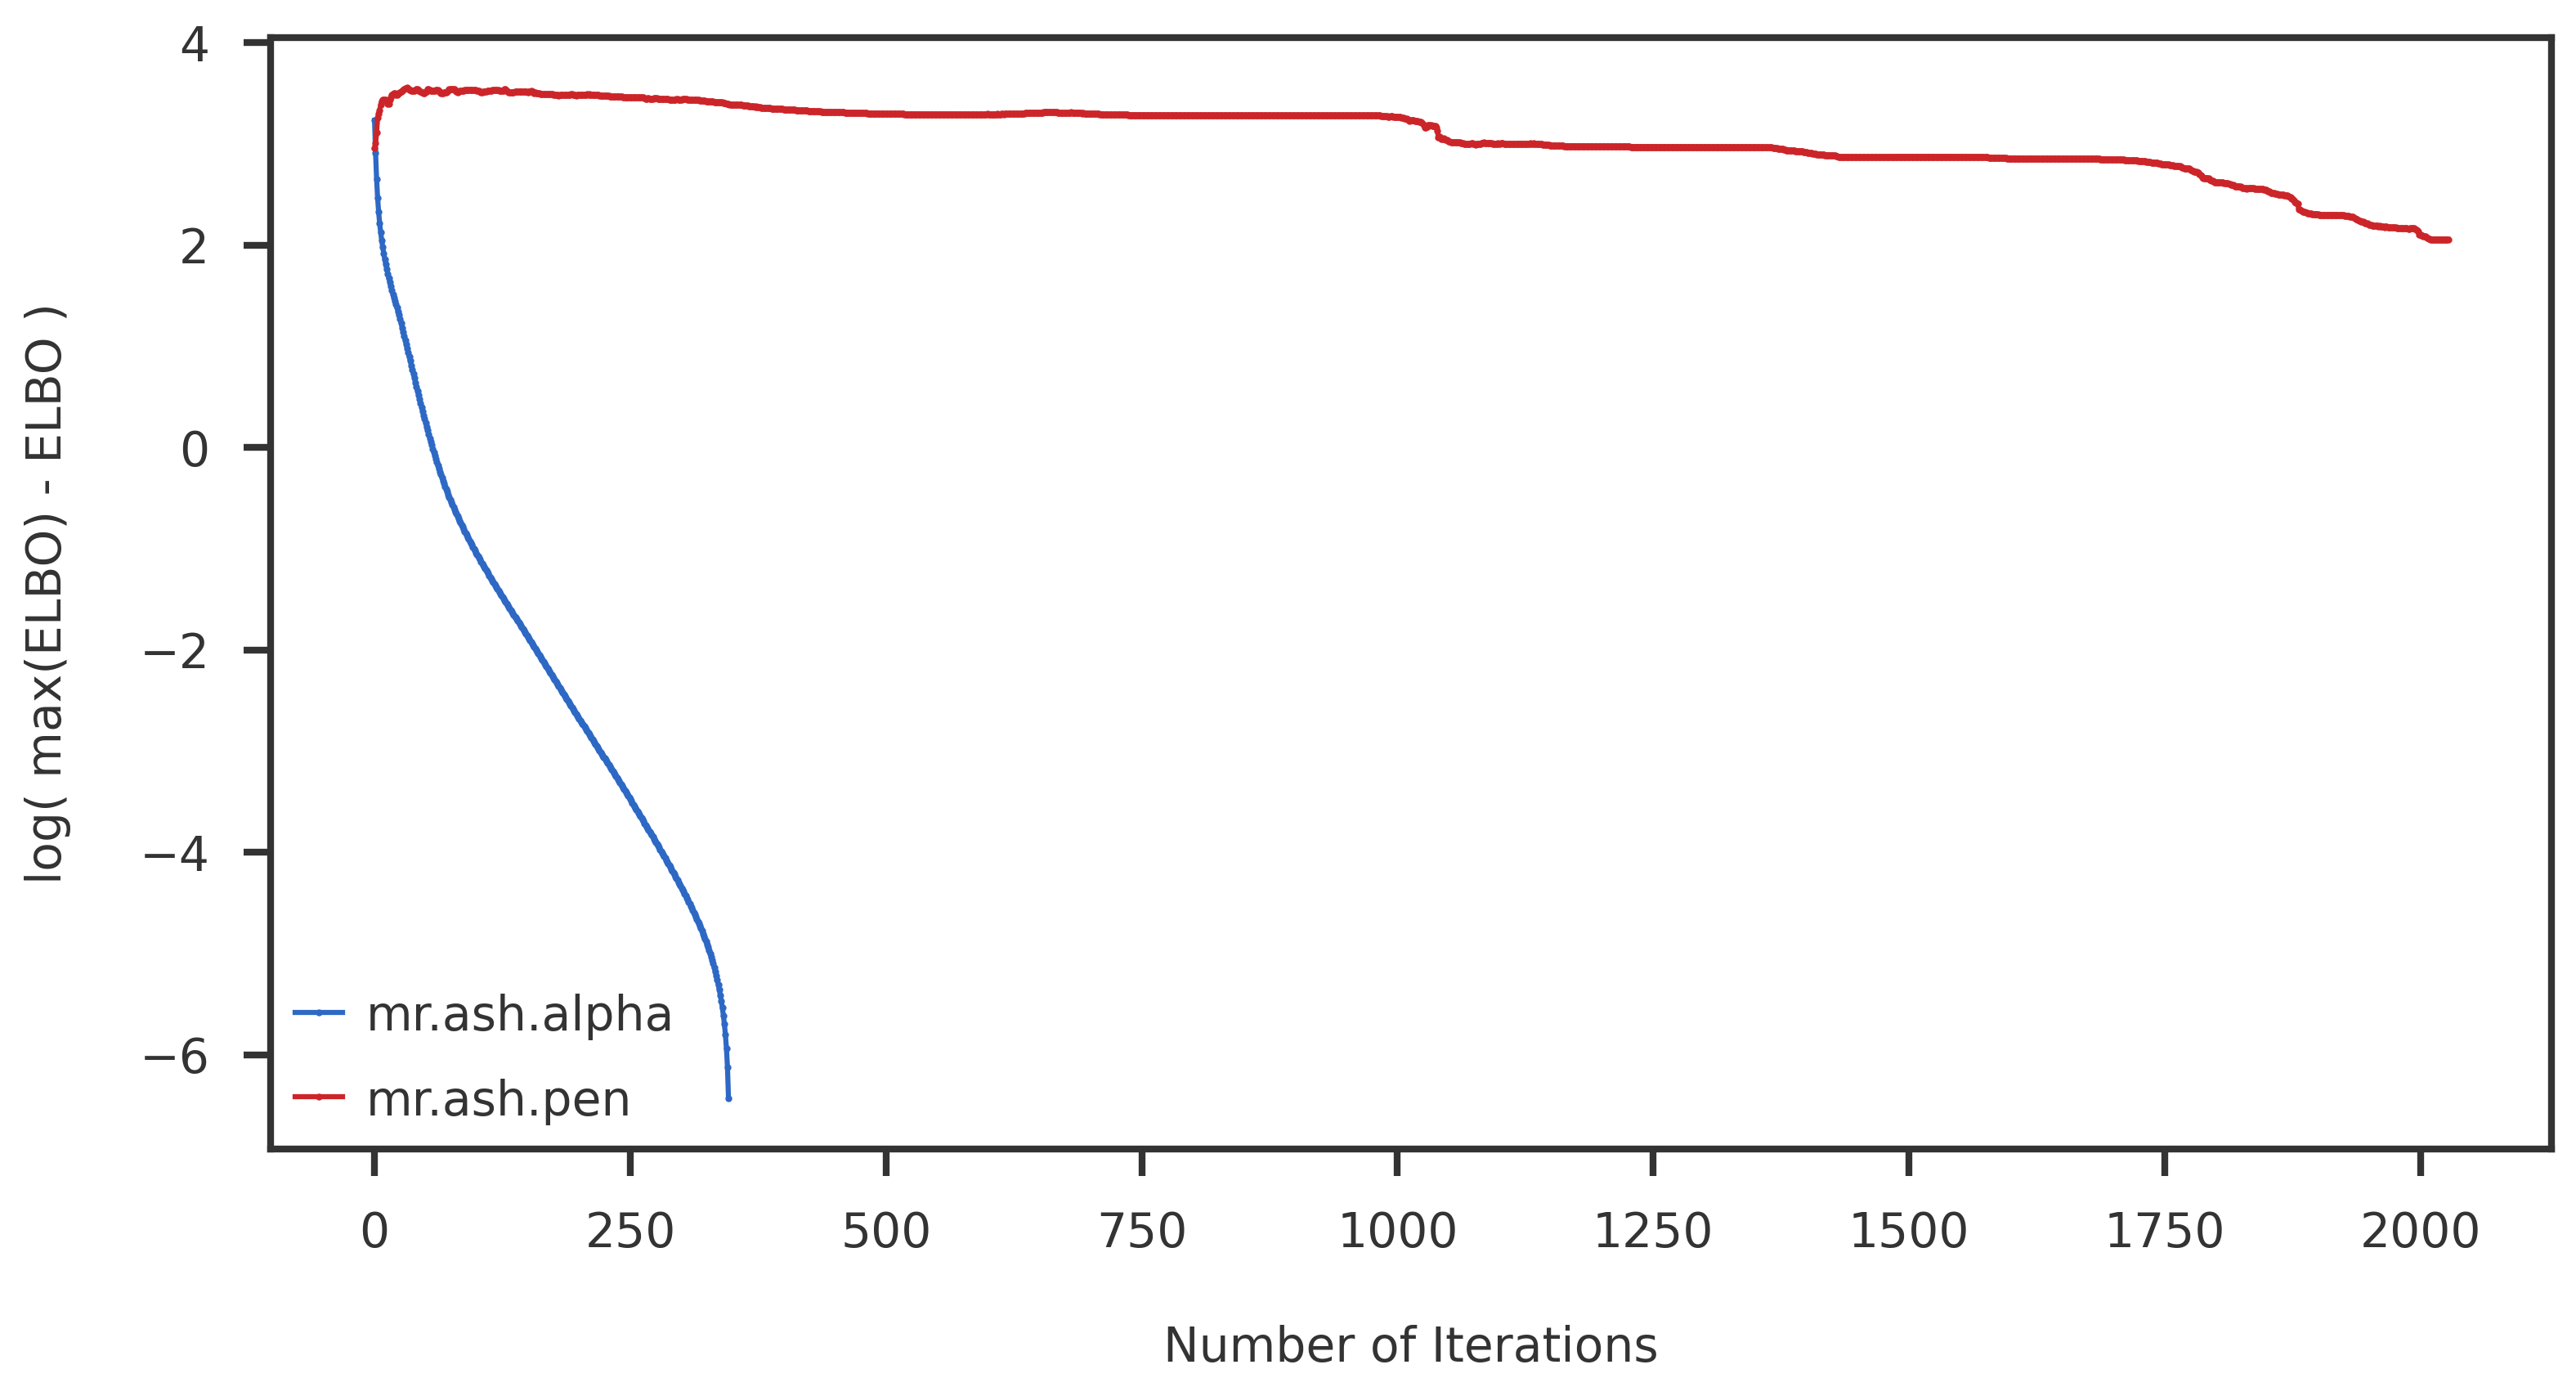

In [10]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
# plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
#                      plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

# kinit   = [0, 0, 0]
# objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
# methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen"]
plot_convergence(objs, methods, kinit)

In [11]:
# objs     = [mrash_r, plr_lbfgs.plr2, plr_eb, mrash_r_init]
# methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
# df       = linreg_summary_df(strue, objs, methods)
objs     = [mrash_r, plr_lbfgs, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

,sigma2,ELBO,niter
True,0.043211,-,-
mr.ash.alpha,0.104509,122.031837,348
mr.ash.pen,0.050676,236.50279,2028
mr.ash.alpha (init),0.104509,122.031837,192


In [14]:
plr_lbfgs.plr2.s2_path

[0.15241520439334583,
 0.10685434164356694,
 0.10453247205802818,
 0.10450822169225846]

In [16]:
plr_lbfgs.plr2.prior

array([9.96212664e-01, 5.00144333e-12, 5.00144333e-12, 5.00144333e-12,
       5.00144333e-12, 5.00144333e-12, 5.00144333e-12, 5.00144333e-12,
       5.00144333e-12, 5.00144333e-12, 5.00144333e-12, 5.00144333e-12,
       5.00144333e-12, 5.00144333e-12, 5.00144333e-12, 5.00144333e-12,
       5.00144333e-12, 5.00144333e-12, 5.00144333e-12, 3.78733579e-03])

In [17]:
plr_lbfgs.plr3.prior

array([0.13214829, 0.1172528 , 0.09132021, 0.0701568 , 0.05531658,
       0.04492054, 0.03740453, 0.03177999, 0.0274446 , 0.02405316,
       0.02146911, 0.01970447, 0.01881602, 0.01884309, 0.01984069,
       0.02201689, 0.02624513, 0.03583023, 0.06074847, 0.12468842])

In [17]:
plr_lbfgs.plr1.coef

array([ 6.02656952e-06,  2.82695361e-05,  2.04810614e-05, ...,
       -1.38877651e-05, -3.32815339e-04,  1.13716119e-01])

In [18]:
plr_lbfgs.plr2._binit

array([ 0.00210603,  0.00861862,  0.00662596, ..., -0.00468949,
       -0.02734569,  0.11437087])

In [19]:
sk

array([0.        , 0.03526492, 0.07177346, 0.10956947, 0.14869835,
       0.18920712, 0.23114441, 0.27456063, 0.31950791, 0.36604026,
       0.41421356, 0.4640857 , 0.51571657, 0.5691682 , 0.62450479,
       0.68179283, 0.74110113, 0.80250093, 0.86606598, 0.93187266])

In [20]:
elbo_py.scalemix(X, y, sk, plr_lbfgs.plr2.coef, plr_lbfgs.plr2.prior, plr_lbfgs.plr2.residual_var)

124.68099810413891

In [21]:
from mrashpen.inference import coordinate_descent_step as cd_step
cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, plr_lbfgs.plr2.prior, plr_lbfgs.plr2.residual_var)

122.03183095534104

In [22]:
## First step in PLR4
wnew = plr_lbfgs.plr3.prior_path[0]
wnew /= np.sum(wnew)
thetanew = plr_lbfgs.plr3.theta_path[0]
bnew = plr_lbfgs.plr3.coef_path[0]
s2new = plr_lbfgs.plr3.s2_path[0]

elbo0 = cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, plr_lbfgs.plr2.prior, plr_lbfgs.plr2.residual_var)
print (f"{elbo0:10.5f} | s, w, b from PLR2")
elbo2 = cd_step.elbo(X, y, sk, bnew, plr_lbfgs.plr2.prior, plr_lbfgs.plr2.residual_var)
print (f"{elbo2:10.5f} | s, w from PLR2 + b from first step of PLR3")
elbo4 = cd_step.elbo(X, y, sk, bnew, wnew, plr_lbfgs.plr2.residual_var)
print (f"{elbo4:10.5f} | s from PLR2 + b, w from first step of PLR3")
elbo5 = cd_step.elbo(X, y, sk, bnew, wnew, s2new)
print (f"{elbo5:10.5f} | s, w, b from first step of PLR2")
print ()
elbo1 = cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, wnew, plr_lbfgs.plr2.residual_var)
print (f"{elbo1:10.5f} | s, b from PLR2 + w from first step of PLR3")

elbo3 = cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, plr_lbfgs.plr2.prior, s2new)
print (f"{elbo3:10.5f} | b, w from PLR2 + s from first step of PLR3")

 122.03183 | s, w, b from PLR2
 149.56968 | s, w from PLR2 + b from first step of PLR3
1256.66776 | s from PLR2 + b, w from first step of PLR3
1256.66778 | s, w, b from first step of PLR2

1249.83465 | s, b from PLR2 + w from first step of PLR3
 122.03183 | b, w from PLR2 + s from first step of PLR3


In [23]:
#invert S
plr_lbfgs.plr2.theta

array([ 0.00168446, -0.00557809, -0.00168173, ..., -0.00731618,
       -0.00301663, -0.00093678])

In [24]:
plr_lbfgs.plr2.coef

array([ 4.82922210e-07, -1.64279416e-06, -4.82136266e-07, ...,
       -2.20109536e-06, -8.70014354e-07, -2.68067273e-07])

In [32]:
plr_lbfgs.plr1._fitobj.x[:2000]

array([ 0.00168446, -0.00557809, -0.00168173, ..., -0.00731618,
       -0.00301663, -0.00093678])

In [33]:
plr_lbfgs.plr2.residual_var

0.10450822169225846

In [40]:
X.shape

(200, 2000)

In [34]:
ylessa = y - np.mean(y)
thetaopt = plr_lbfgs.plr2.theta
s2opt = plr_lbfgs.plr2.residual_var
wopt  = plr_lbfgs.plr2.prior

In [38]:
pmash = PenalizedMrASH(X, ylessa, thetaopt, np.sqrt(s2opt), wopt, sk, is_prior_scaled = True)

In [39]:
pmash.shrink_b

array([ 4.82922210e-07, -1.64279416e-06, -4.82136266e-07, ...,
       -2.20109536e-06, -8.70014354e-07, -2.68067273e-07])

In [54]:
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.models.normal_means_ash        import NormalMeansASH

def shrinkage_operator(nm, dj, is_prior_scaled = True):
    '''
    posterior expectation of b under NM model
    calculated using Tweedie's formula

    Returns shrinkage operator M(b)
    Dimensions:
        M: vector of size P
        M_bgrad: vector of size P
        M_wgrad: matrix of size P x K
        M_sgrad: vector of size P
    '''
    M       = nm.y + nm.yvar * nm.logML_deriv
    M_bgrad = 1       + nm.yvar * nm.logML_deriv2
    M_wgrad = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
    if is_prior_scaled:
        M_s2grad = (nm.logML_deriv / dj) + (nm.yvar * nm.logML_deriv_s2deriv)
    else:
        M_s2grad = (nm.logML_deriv + nm.yvar * nm.logML_deriv_s2deriv) / dj
    return M, M_bgrad, M_wgrad, M_s2grad

def invert_Mop(X, b, s2, wk, sk, is_prior_scaled = True, max_iter = 100, tol = 1e-8):
    n, p = X.shape
    dj = np.sum(np.square(X), axis = 0)
    theta = np.zeros(p)
    for itr in range(max_iter):
        if is_prior_scaled:
            nmash = NormalMeansASHScaled(theta, np.sqrt(s2), wk, sk, d = dj)
        else:
            vj = np.sqrt(s2 / dj)
            nmash = NormalMeansASH(theta, vj, wk, sk)
        M_theta, M_theta_bgrad, _, _ = shrinkage_operator(nmash, dj)
        theta_new = theta - (M_theta - b) / M_theta_bgrad
        diff = np.sum(np.square(theta_new - theta))
        print (diff)
        theta = theta_new
        if diff <= tol:
            break
    return theta

def winit_from_binit(binit, sk, wk = None):
    k = sk.shape[0]

In [55]:
theta_from_inv = invert_Mop(X, plr_lbfgs.plr2.coef, plr_lbfgs.plr2.residual_var,
                            plr_lbfgs.plr2.prior, sk)

98671400.98394793
101715870.30887303
27062.172991832125
3.5671599608909605e-11


In [59]:
s2init

0.05067581241863296

In [61]:
theta_init = invert_Mop(X, lasso_b, s2init, wk, sk)

19.62794959698484
3.1316665892924065
3.631636926553333e-06
2.429870501788543e-12


In [63]:
theta_init[np.abs(lasso_b) > 0.01]

array([-0.08752351, -0.01828273,  0.0728655 ,  1.15919834, -1.08879061,
       -0.04598542, -1.10776158, -0.03876027, -0.97894877, -0.0569805 ,
       -0.04636619, -0.03088719,  0.04110099, -0.02668327, -0.04984126,
        0.06123227,  0.02003374, -0.31411771,  1.32920774,  0.67241797,
       -0.04010217,  0.03710461, -0.0801043 , -0.05182807,  0.02108923,
       -0.04335766,  0.05228984])

In [64]:
lasso_b[np.abs(lasso_b) > 0.01]

array([-0.08443814, -0.01247918,  0.06952257,  1.15245504, -1.08242168,
       -0.04132255, -1.10129228, -0.03333598, -0.97315299, -0.0530984 ,
       -0.04173867, -0.02467944,  0.03593737, -0.02028762, -0.04550787,
        0.05754109,  0.01398249, -0.31125017,  1.32154164,  0.66813013,
       -0.03482808,  0.0314953 , -0.0769049 , -0.0476398 ,  0.0149215 ,
       -0.03843524,  0.04813299])

In [65]:
wk

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [69]:
# E-step
post_jk = 

20

In [153]:
import scipy.stats
scipy.stats.norm(0, 1e-12).logpdf(0)

26.712082582723873

In [117]:
np.exp(- 0.5 * np.square(binit[0] / sk[1]) - 0.5 * np.log(2 * np.pi * sk[1] * sk[1]))

0.6436276628400429

In [89]:
sk[nz_Sidx]

array([0.03526492, 0.07177346, 0.10956947, 0.14869835, 0.18920712,
       0.23114441, 0.27456063, 0.31950791, 0.36604026, 0.41421356,
       0.4640857 , 0.51571657, 0.5691682 , 0.62450479, 0.68179283,
       0.74110113, 0.80250093, 0.86606598, 0.93187266])

In [167]:
X = lasso_b.copy()

delta_logprob_nonzeroX = np.repeat(-5e23, p) # scipy.stats.norm(0, 1e-12).logpdf(1)
delta_logprob_zeroX = np.repeat(26.7121, p)  # scipy.stats.norm(0, 1e-12).logpdf(0)
nonzero_Xmask = np.array(X  != 0, dtype = bool)
nonzero_smask = np.array(sk != 0, dtype = bool)
assert (np.sum(~nonzero_smask) <= 1)
log_prob = np.zeros((p, k))
if np.sum(~nonzero_smask) == 1:
    log_prob[nonzero_Xmask, ~nonzero_smask] = delta_logprob_nonzeroX[nonzero_Xmask]
    log_prob[~nonzero_Xmask, ~nonzero_smask] = delta_logprob_zeroX[~nonzero_Xmask]

In [168]:
log_prob

array([[26.7121,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [26.7121,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [26.7121,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [26.7121,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [26.7121,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [26.7121,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

In [166]:
log_prob

(35,)

In [101]:
nzS_mask = np.array(sk != 0, dtype = bool)

In [154]:
np.repeat(1.2, 19)

array([1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2,
       1.2, 1.2, 1.2, 1.2, 1.2, 1.2])

In [175]:
binit = lasso_b[np.abs(lasso_b) > 0.01]

p = binit.shape[0]
k = sk[1:].shape[0]
scipy.stats.norm(0, sk[1:]).logpdf(binit[1])

array([ 2.36331617,  1.70018674,  1.28577216,  0.98337544,  0.74379945,
        0.54431668,  0.37261173,  0.22127197,  0.08549228, -0.03801878,
       -0.15161401, -0.25703334, -0.3555996 , -0.44834191, -0.53607661,
       -0.61946211, -0.69903717, -0.77524816, -0.84846909])

In [265]:
''' 
log(sum(exp(z))) = M + log(sum(exp(z - M)))
z is a matrix of shape (p, k)
Sum is over k
'''
def log_sum_exponent(z, axis = 1): 
    zmax = np.max(z, axis = axis)
    if axis == 0:
        sub_zmax = zmax.reshape(1, -1)
    elif axis == 1:
        sub_zmax = zmax.reshape(-1, 1)
    logsum = np.log(np.sum(np.exp(z - sub_zmax), axis = axis)) + zmax
    return logsum

def em_step_mixture_gaussians(X, sk, wk):
    p = X.shape[0]
    k = wk.shape[0]
    nonzero_widx  = np.where(wk != 0)[0]
    nonzero_sidx  = np.where(sk != 0)[0]
    logLjk = matrix_lognormpdf(X, sk)
    wknew = np.zeros(k)
    logwkLjk = logLjk[:, nonzero_widx] + np.log(wk[nonzero_widx])
    log_partition_func = log_sum_exponent(logwkLjk, axis = 1).reshape(-1, 1)
    log_nonzeroFjk = logwkLjk - log_partition_func
    sum_Fjk = log_sum_exponent(log_nonzeroFjk, axis = 0)
    wknew[nonzero_widx] = np.exp(sum_Fjk) / p
    return wknew

def matrix_lognormpdf(X, sk):
    p = X.shape[0]
    k = sk.shape[0]
    delta_logprob_nonzeroX = np.repeat(-5e23, p) # scipy.stats.norm(0, 1e-12).logpdf(1)
    delta_logprob_zeroX = np.repeat(26.7121, p)  # scipy.stats.norm(0, 1e-12).logpdf(0)
    nonzero_Xmask = np.array(X  != 0, dtype = bool)
    nonzero_smask = np.array(sk != 0, dtype = bool)
    assert (np.sum(~nonzero_smask) <= 1)
    log_prob = np.zeros((p, k))
    if np.sum(~nonzero_smask) == 1:
        log_prob[nonzero_Xmask, ~nonzero_smask] = delta_logprob_nonzeroX[nonzero_Xmask]
        log_prob[~nonzero_Xmask, ~nonzero_smask] = delta_logprob_zeroX[~nonzero_Xmask]
    nzk = np.sum(nonzero_smask)
    nzSK = sk[nonzero_smask].reshape(1, nzk)
    log_prob[:, nonzero_smask]  = - 0.5 * np.square(X.reshape(p, 1) / nzSK)
    log_prob[:, nonzero_smask] += - 0.5 * np.log(2 * np.pi * np.square(nzSK))
    return log_prob

def fit_g_from_binit(b, sk, wk, max_iter = 1000, tol = 1e-3):
    for itr in range(max_iter):
        wknew = em_step_mixture_gaussians(b, sk, wk)
        diff = np.sum(np.abs(wk - wknew))
        wk = wknew
        if diff <= tol:
            break
    return wk

In [273]:
fit_g_from_binit(lasso_b, sk, wk)

array([9.82500000e-01, 1.17152256e-02, 1.81476957e-03, 0.00000000e+00,
       4.42981744e-05, 1.76428226e-05, 8.84103293e-06, 5.39866440e-06,
       4.28851977e-06, 4.85479921e-06, 7.96364387e-06, 1.69993362e-05,
       4.01531583e-05, 9.19306631e-05, 1.89229687e-04, 3.40128638e-04,
       5.32784535e-04, 7.35358560e-04, 9.08563892e-04, 1.02156871e-03])

In [234]:
wk[3] = 0
wk = wk / np.sum(wk)

In [235]:
wk

array([0.05263158, 0.05263158, 0.05263158, 0.        , 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158])

In [236]:
p = X.shape[0]
k = wk.shape[0]
nonzero_widx  = np.where(wk != 0)[0]
nonzero_sidx  = np.where(sk != 0)[0]
logLjk = matrix_lognormpdf(X, sk)
Fjk = np.zeros((p, k))
logwkLjk = logLjk[:, nonzero_widx] + np.log(wk[nonzero_widx])
log_partition_func = log_sum_exponent(logwkLjk, axis = 1).reshape(-1, 1)
Fjk[:, nonzero_widx] = np.exp(logwkLjk - log_partition_func)

In [262]:
np.sum(Fjk, axis = 0) / p

array([9.82500000e-01, 3.42154634e-03, 2.35961114e-03, 0.00000000e+00,
       1.29874866e-03, 1.05303938e-03, 8.85345338e-04, 7.66356969e-04,
       6.82528937e-04, 6.28148373e-04, 5.99759286e-04, 5.92649107e-04,
       6.00512447e-04, 6.16765001e-04, 6.35808911e-04, 6.53616099e-04,
       6.67724474e-04, 6.76935196e-04, 6.80936159e-04, 6.79968263e-04])

In [267]:
np.sum(em_step_mixture_gaussians(X, sk, wk))

1.0000000000000002

In [246]:
log_sum_exponent(log_nonzeroFjk, axis = 0)

ValueError: operands could not be broadcast together with shapes (2000,19) (19,1) 

In [251]:
zmax = np.max(log_nonzeroFjk, axis = 0)
zmax.shape

(19,)

In [250]:
np.log(np.sum(np.exp(log_nonzeroFjk - zmax), axis = axis)) + zmax

ValueError: operands could not be broadcast together with shapes (2000,19) (20,1) 

In [255]:
np.log(np.sum(np.exp(log_nonzeroFjk - zmax.reshape(1, -1)), axis = 0))

array([7.58324752, 3.01277439, 3.29323079, 3.08683121, 3.05638717,
       3.05027316, 2.93518165, 2.80287873, 2.742842  , 2.74103235,
       2.69552329, 2.61707645, 2.59217792, 2.5209254 , 2.42045101,
       2.26888575, 2.12819662, 2.01858302, 1.93177439])

In [195]:
np.sum(logwkLjk - np.max(logwkLjk, axis = 0), axis = 1)

array([0., 0., 0., ..., 0., 0., 0.])

In [121]:
p = lasso_b.shape[0]
k = sk.shape[0]
norm_pdf = np.zeros((p, k))
nzS_mask = np.array(sk != 0, dtype = bool) # mask for non-zero S
spike_prob = np.array(lasso_b == 0, dtype = bool) * 1
assert(np.sum(~nzS_mask) <= 1)
nzk = np.sum(nzS_mask)
log_prob1  = - 0.5 * np.square(lasso_b.reshape(p, 1) / sk[nzS_mask].reshape(1, nzk))
log_prob2  = - 0.5 * np.log(2 * np.pi * np.square(sk[nzS_mask].reshape(1, nzk)))
if np.sum(~nzS_mask) == 1:
    norm_pdf[:, ~nzS_mask] = spike_prob.reshape(p, 1)
norm_pdf[:, nzS_mask] = np.exp(log_prob1 + log_prob2)

In [129]:
np.sum(norm_pdf[:, nzS_mask], axis = 1)

array([37.26631445, 37.26631445, 37.26631445, ..., 37.26631445,
       37.26631445, 37.26631445])

In [114]:
sk[1]

0.03526492384137758

In [66]:
# plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, is_prior_scaled = True,
#                 debug = False, display_progress = False, calculate_elbo = True, maxiter = 2000)
# plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = s2init)

plr_init = PLR(method = 'L-BFGS-B', optimize_b = True, optimize_w = True, optimize_s = True, is_prior_scaled = True,
               debug = False, display_progress = False, calculate_elbo = True, maxiter = 4000)
plr_init.fit(X, y, sk, binit = theta_init, winit = wk, s2init = s2init, unshrink_binit = False)

mr.ash.pen terminated at iteration 1950.


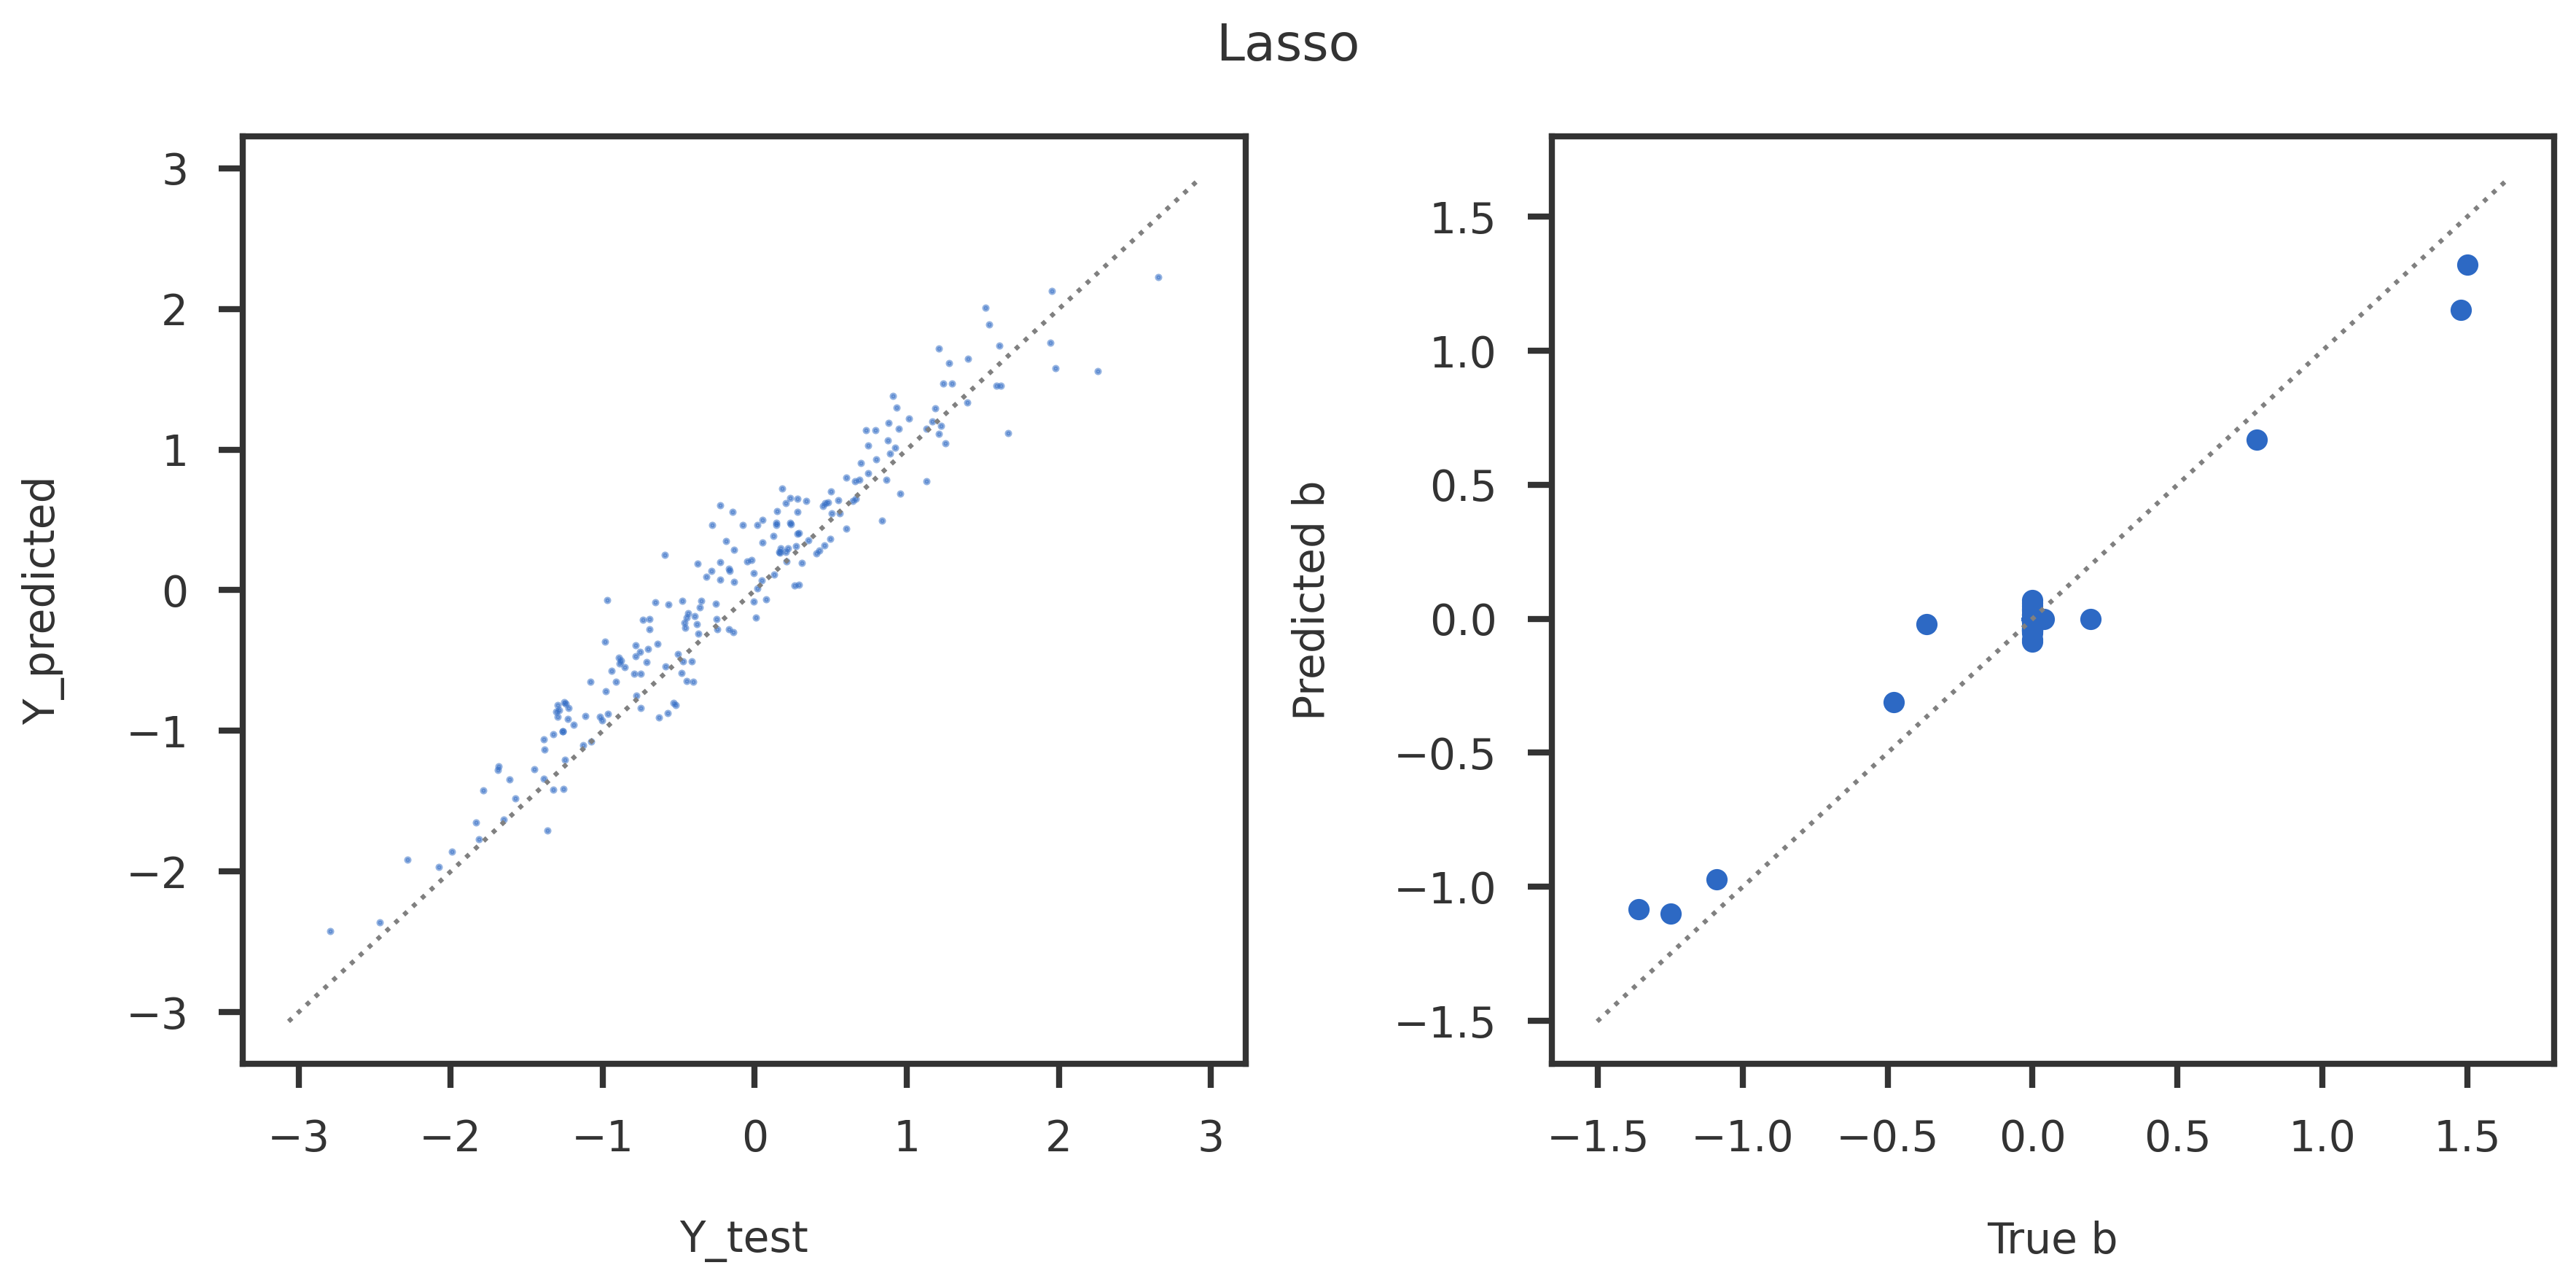

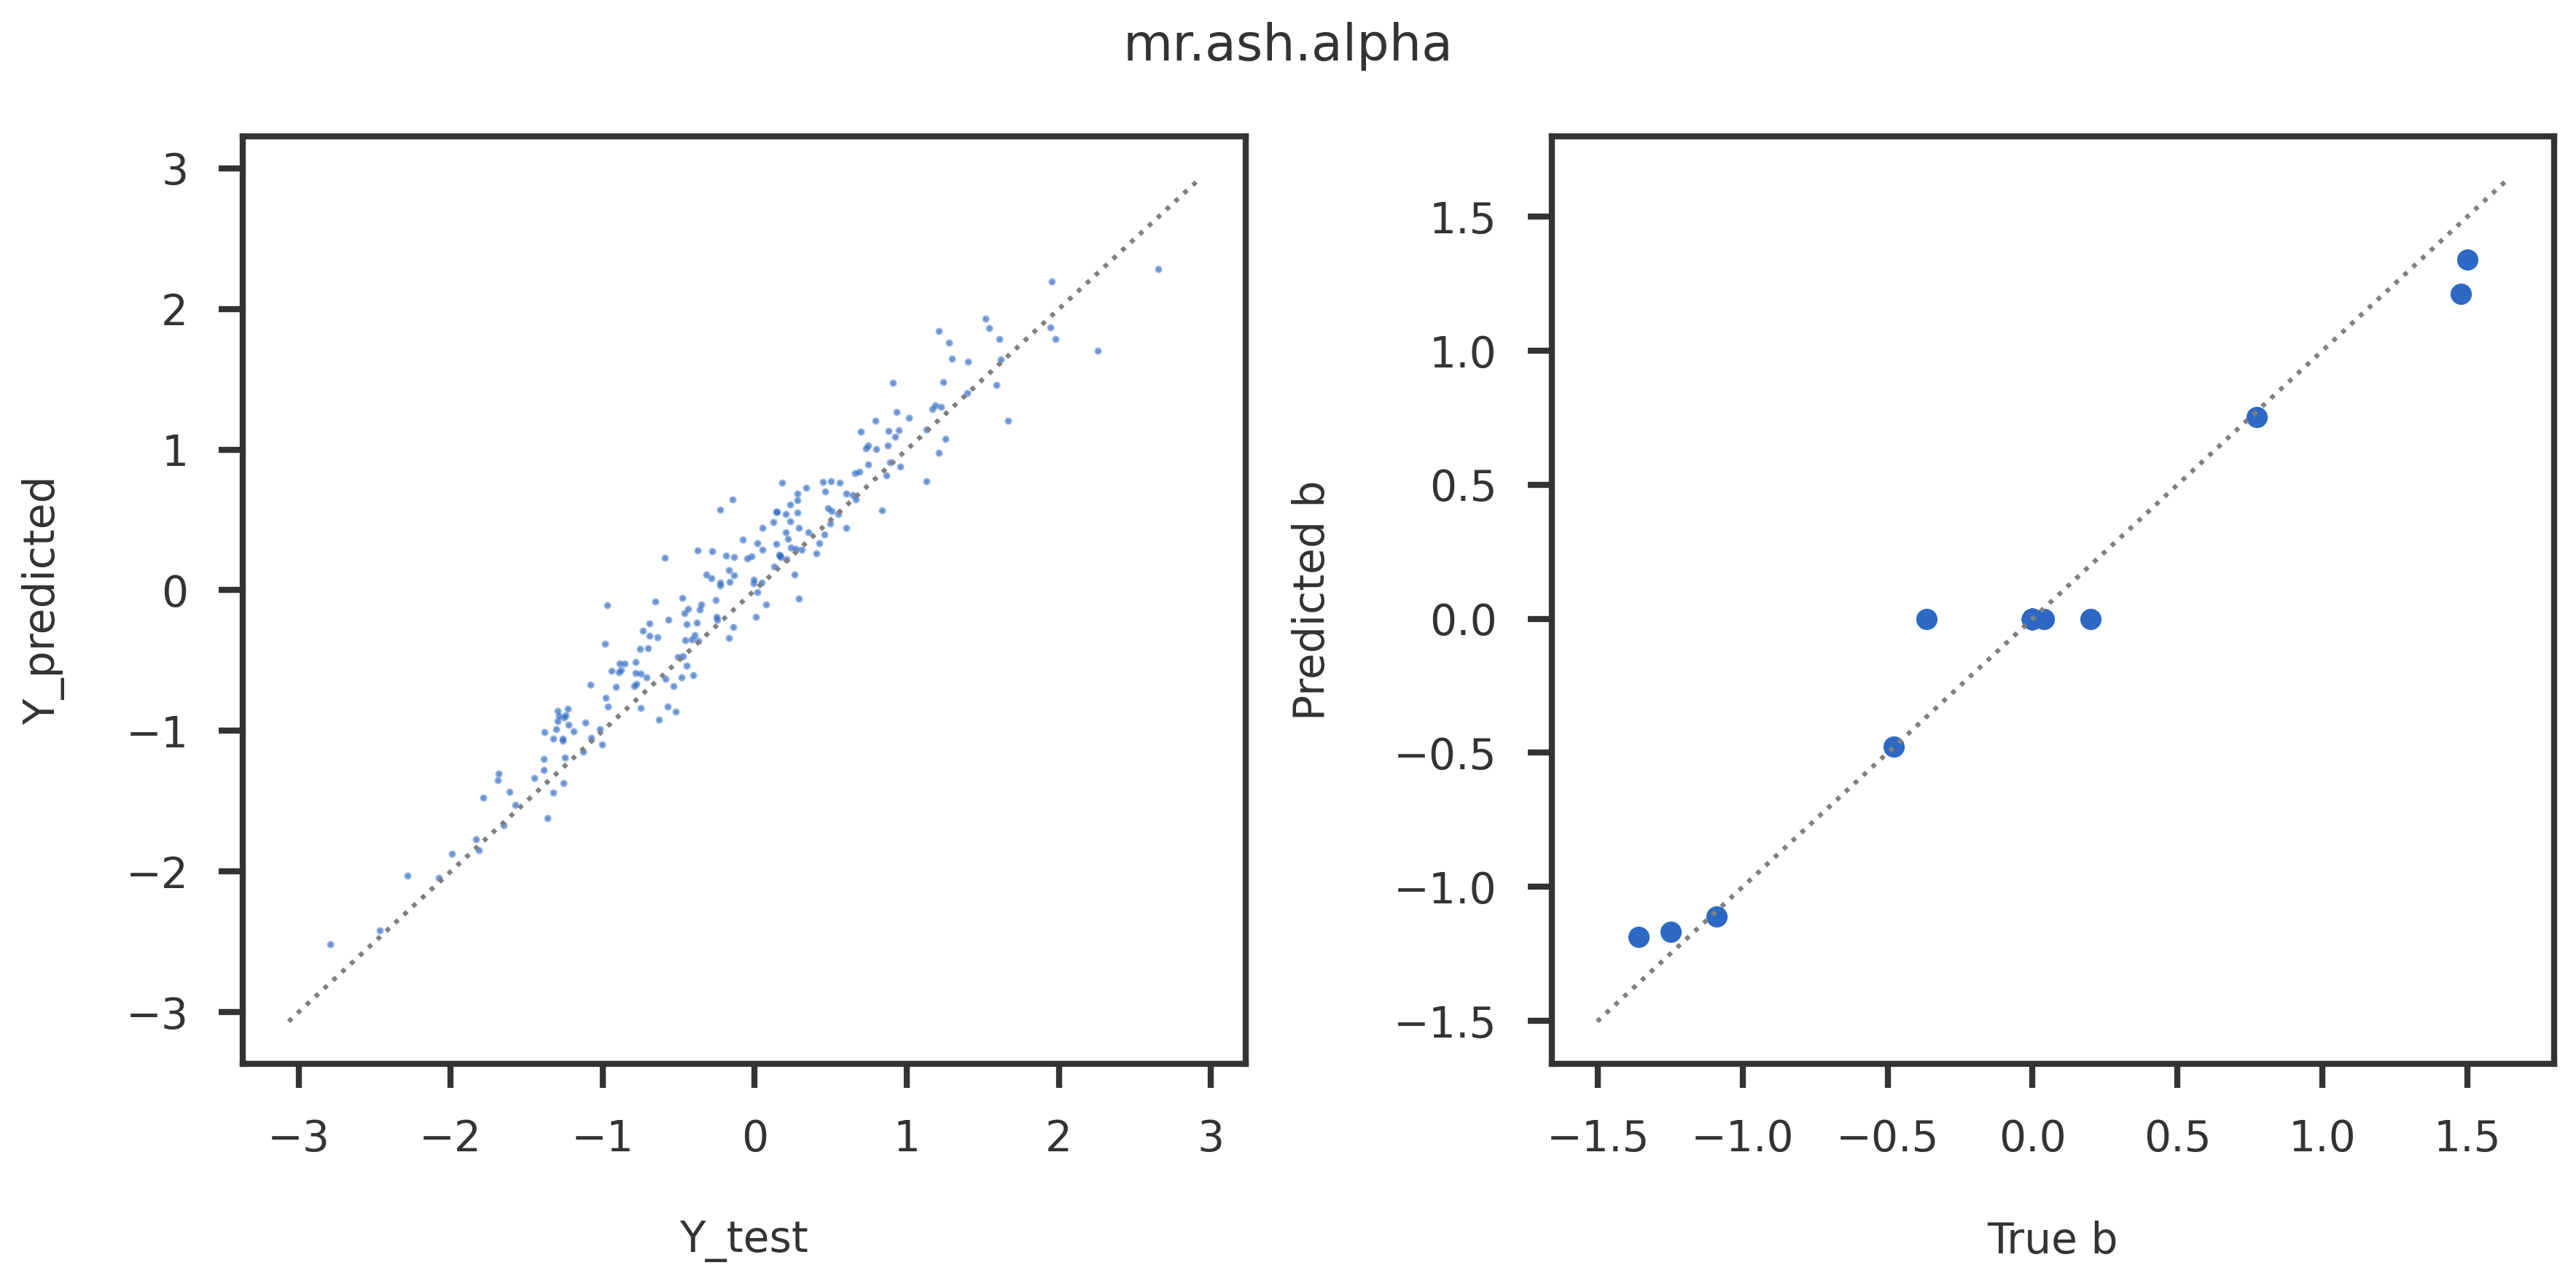

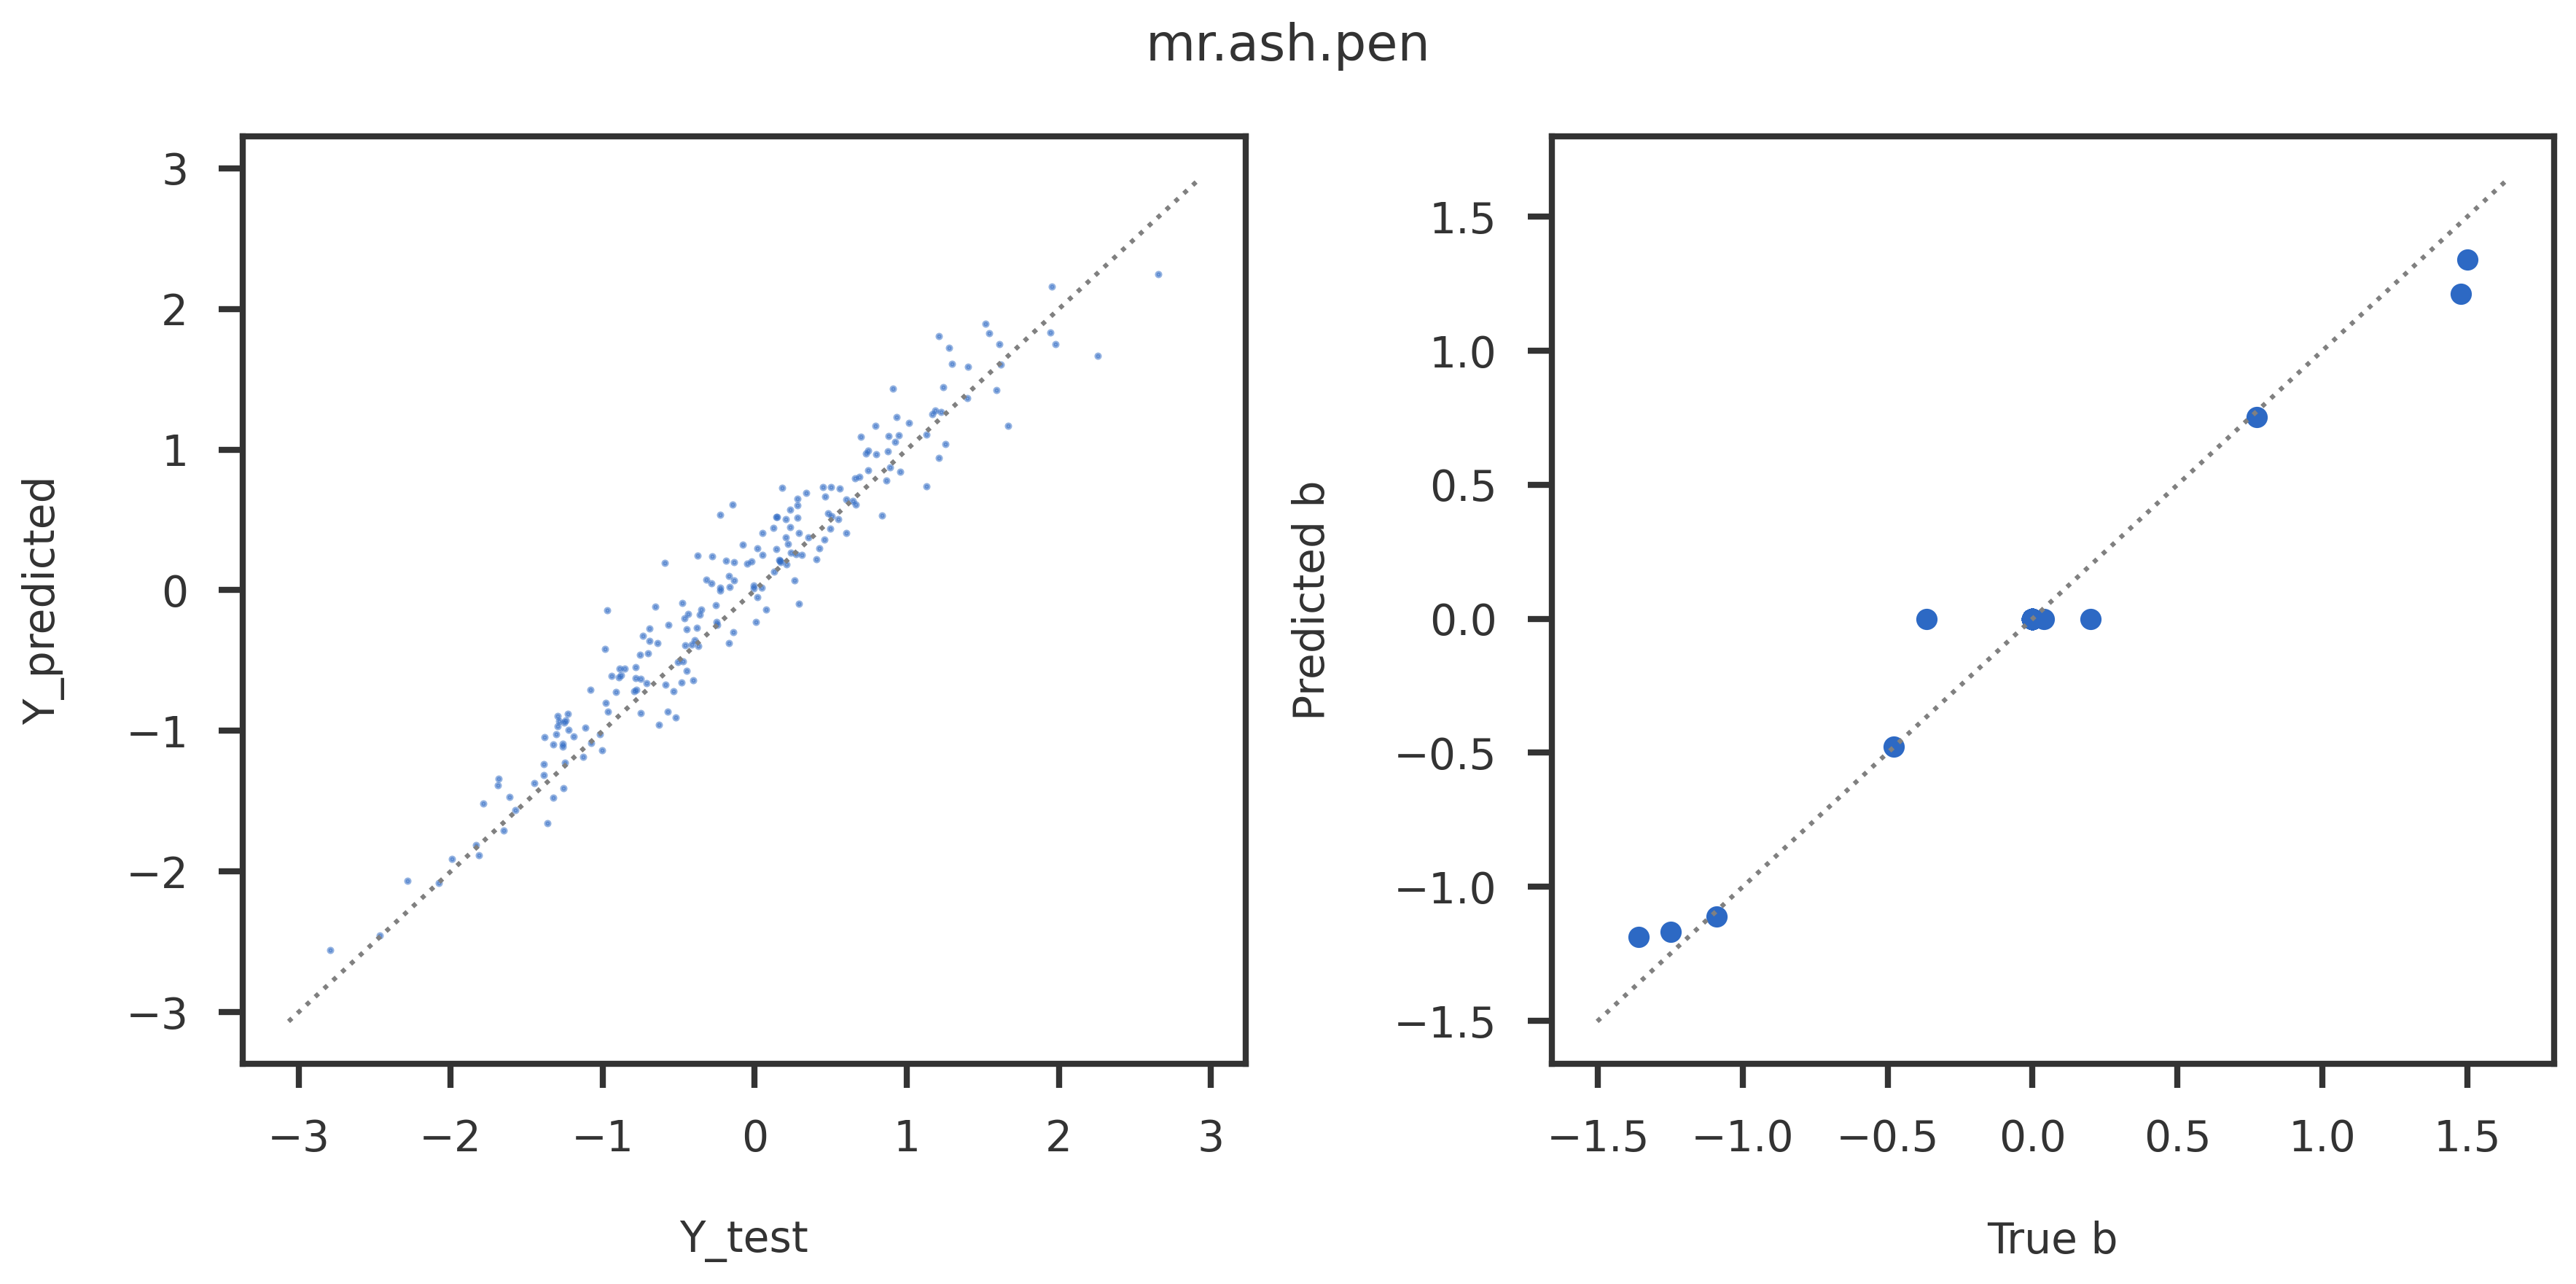

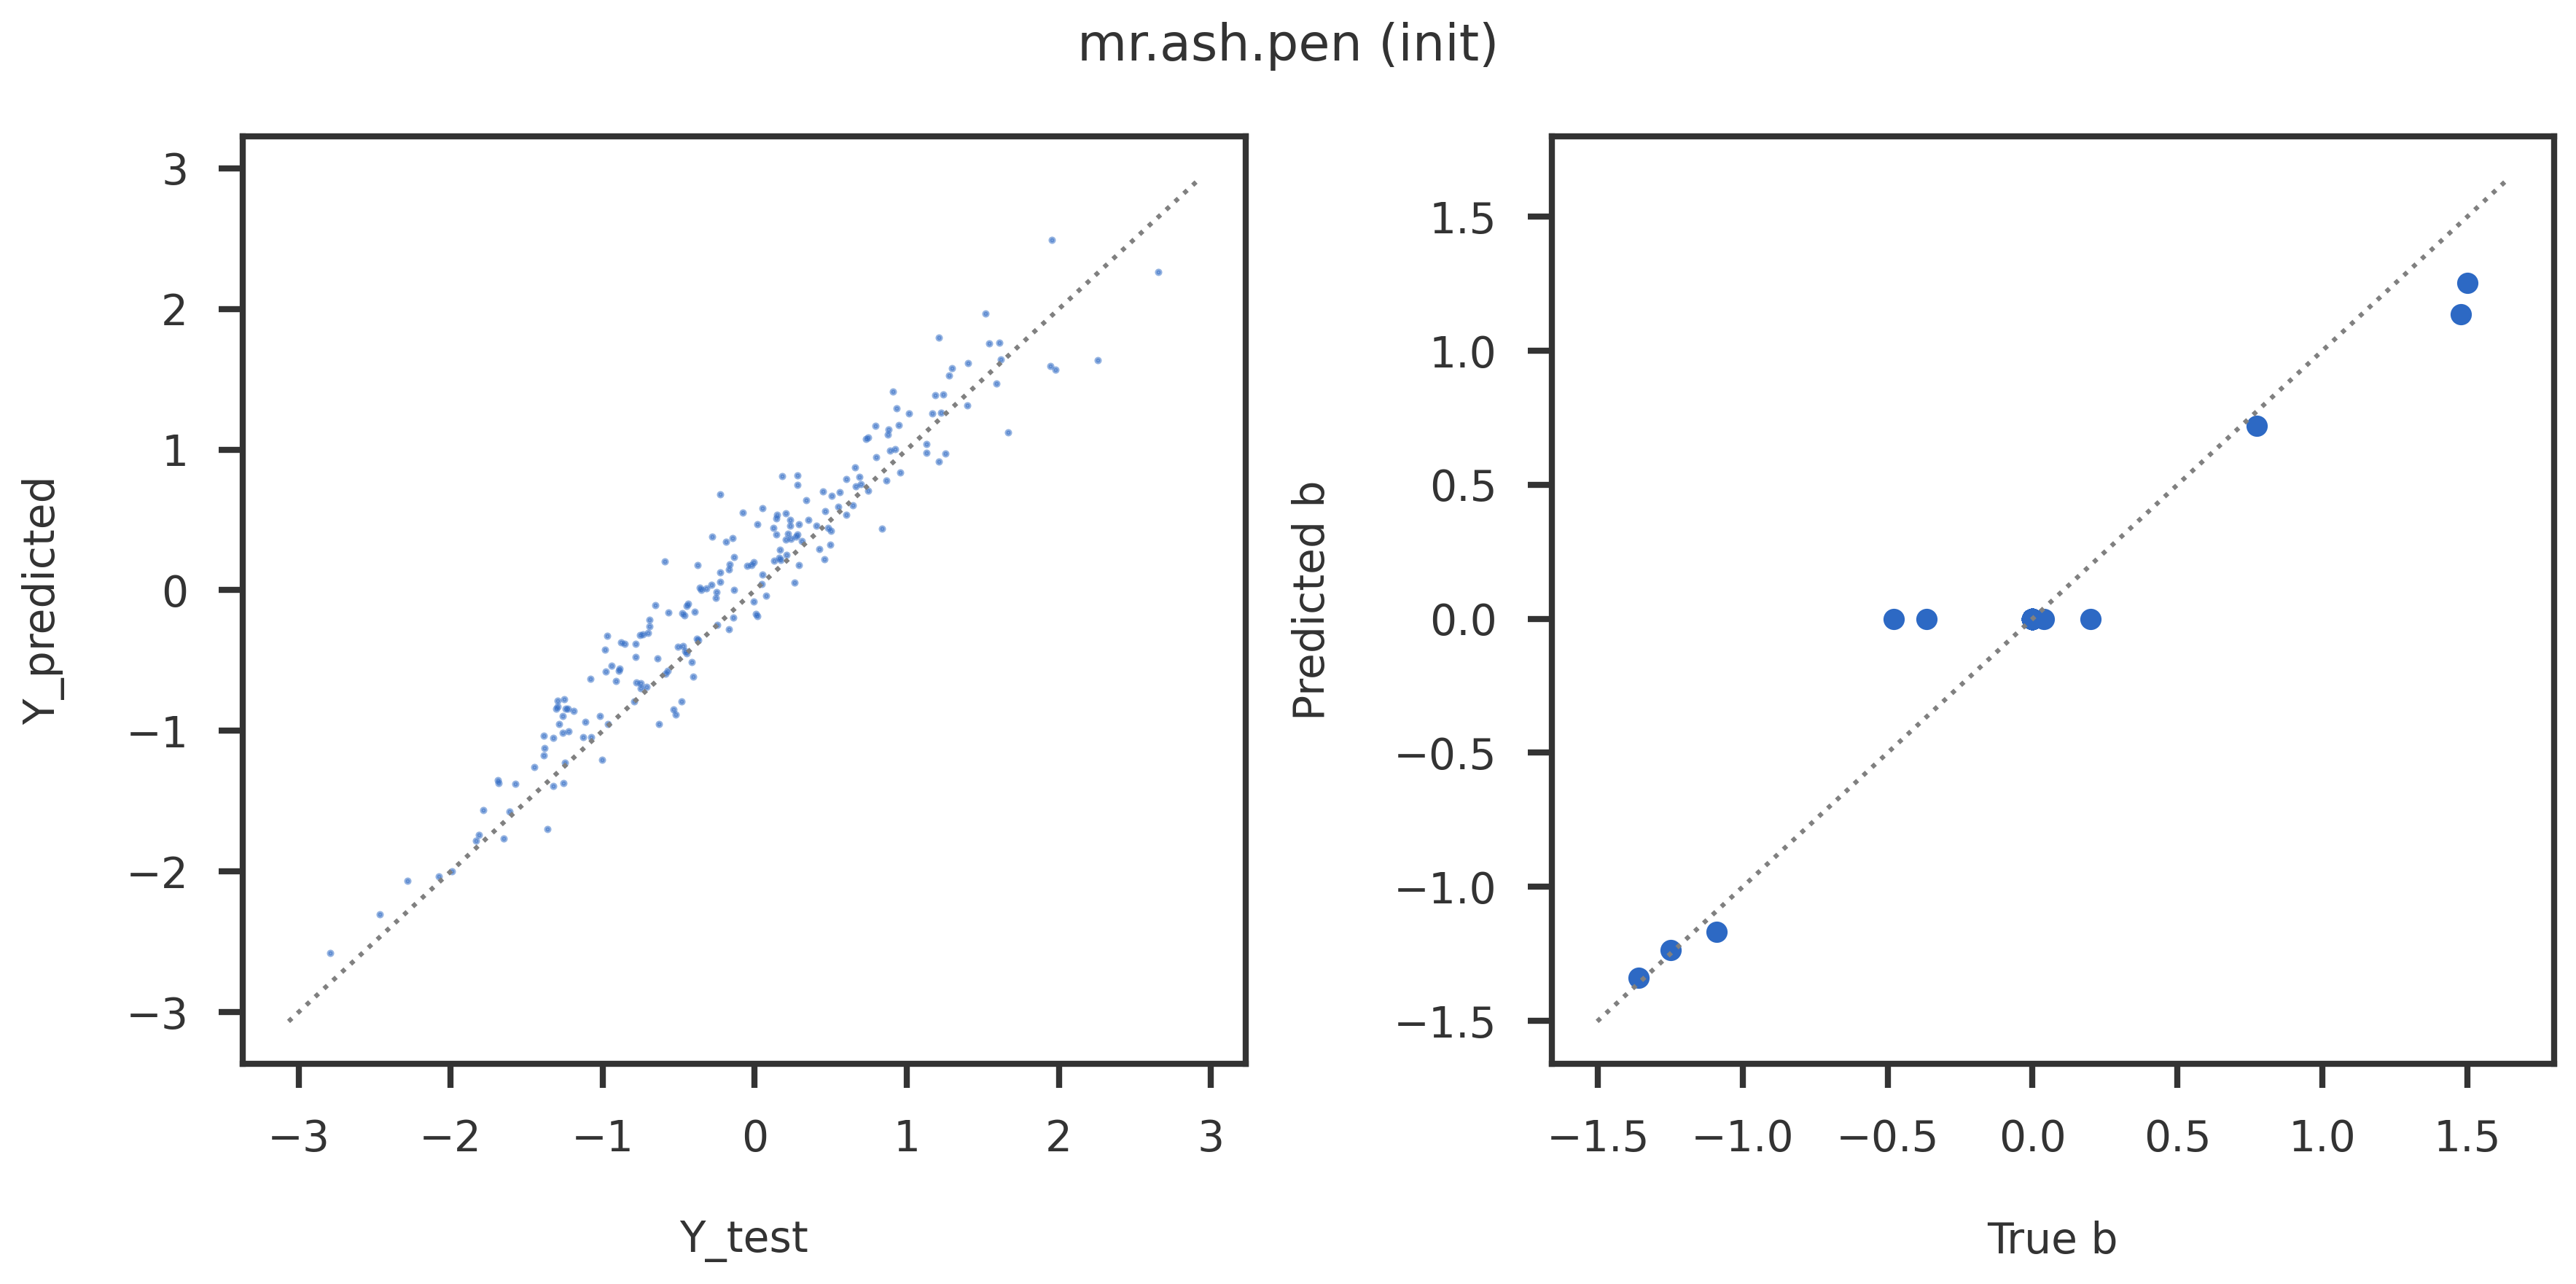

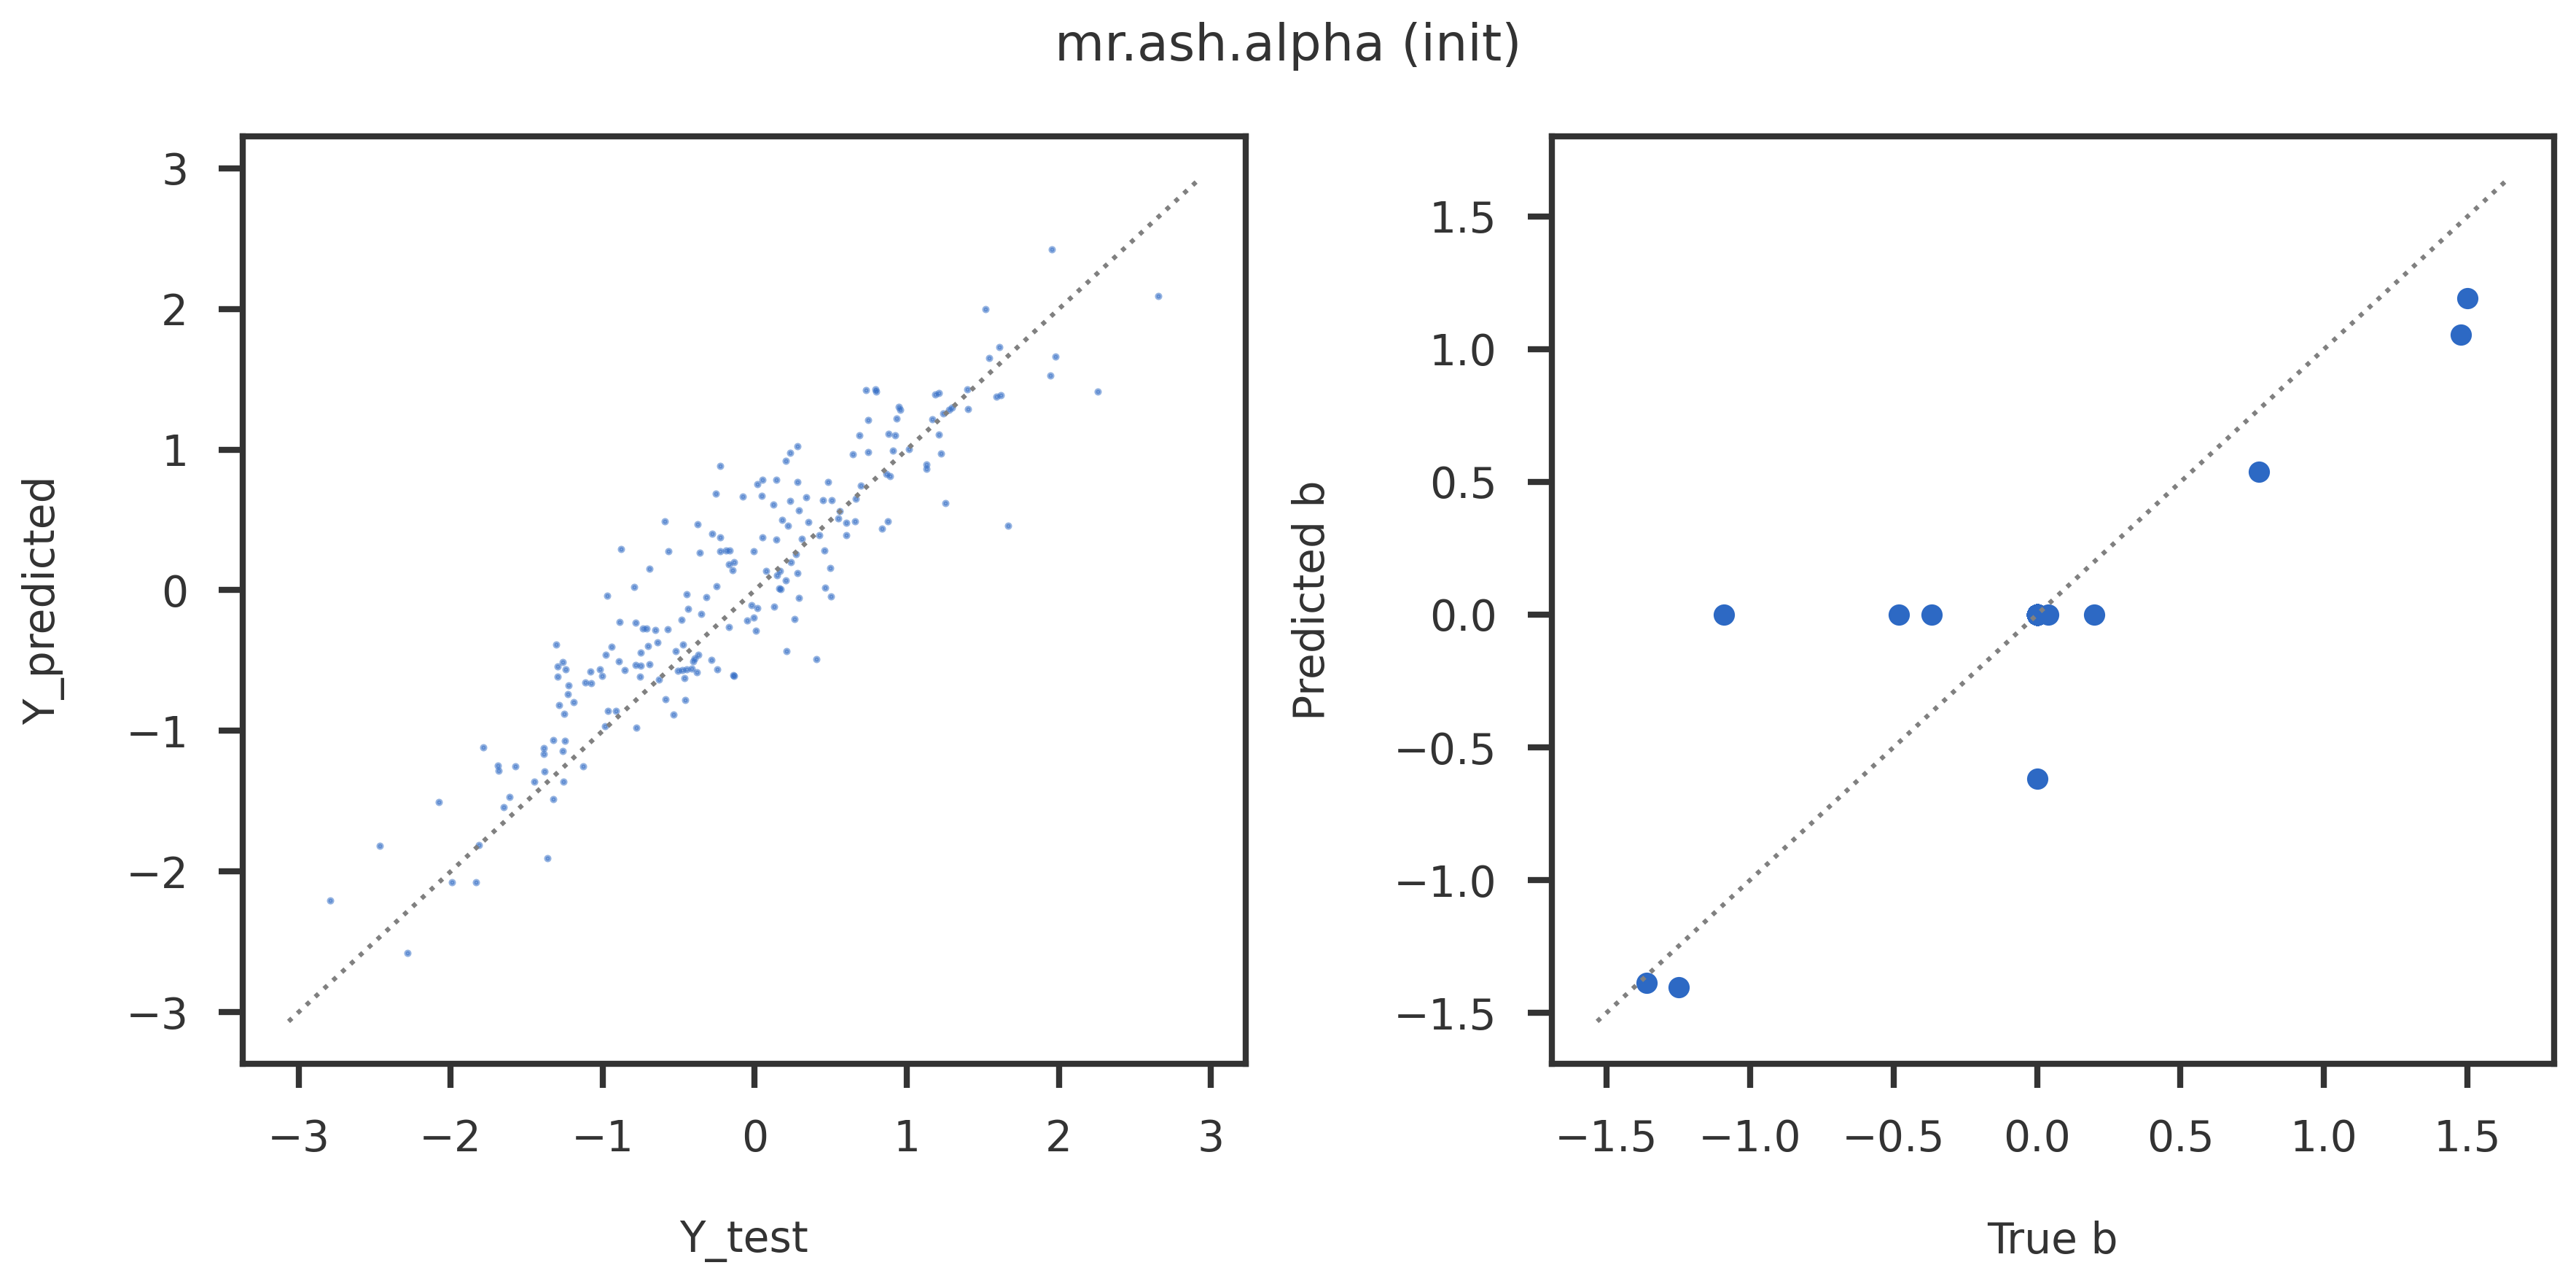

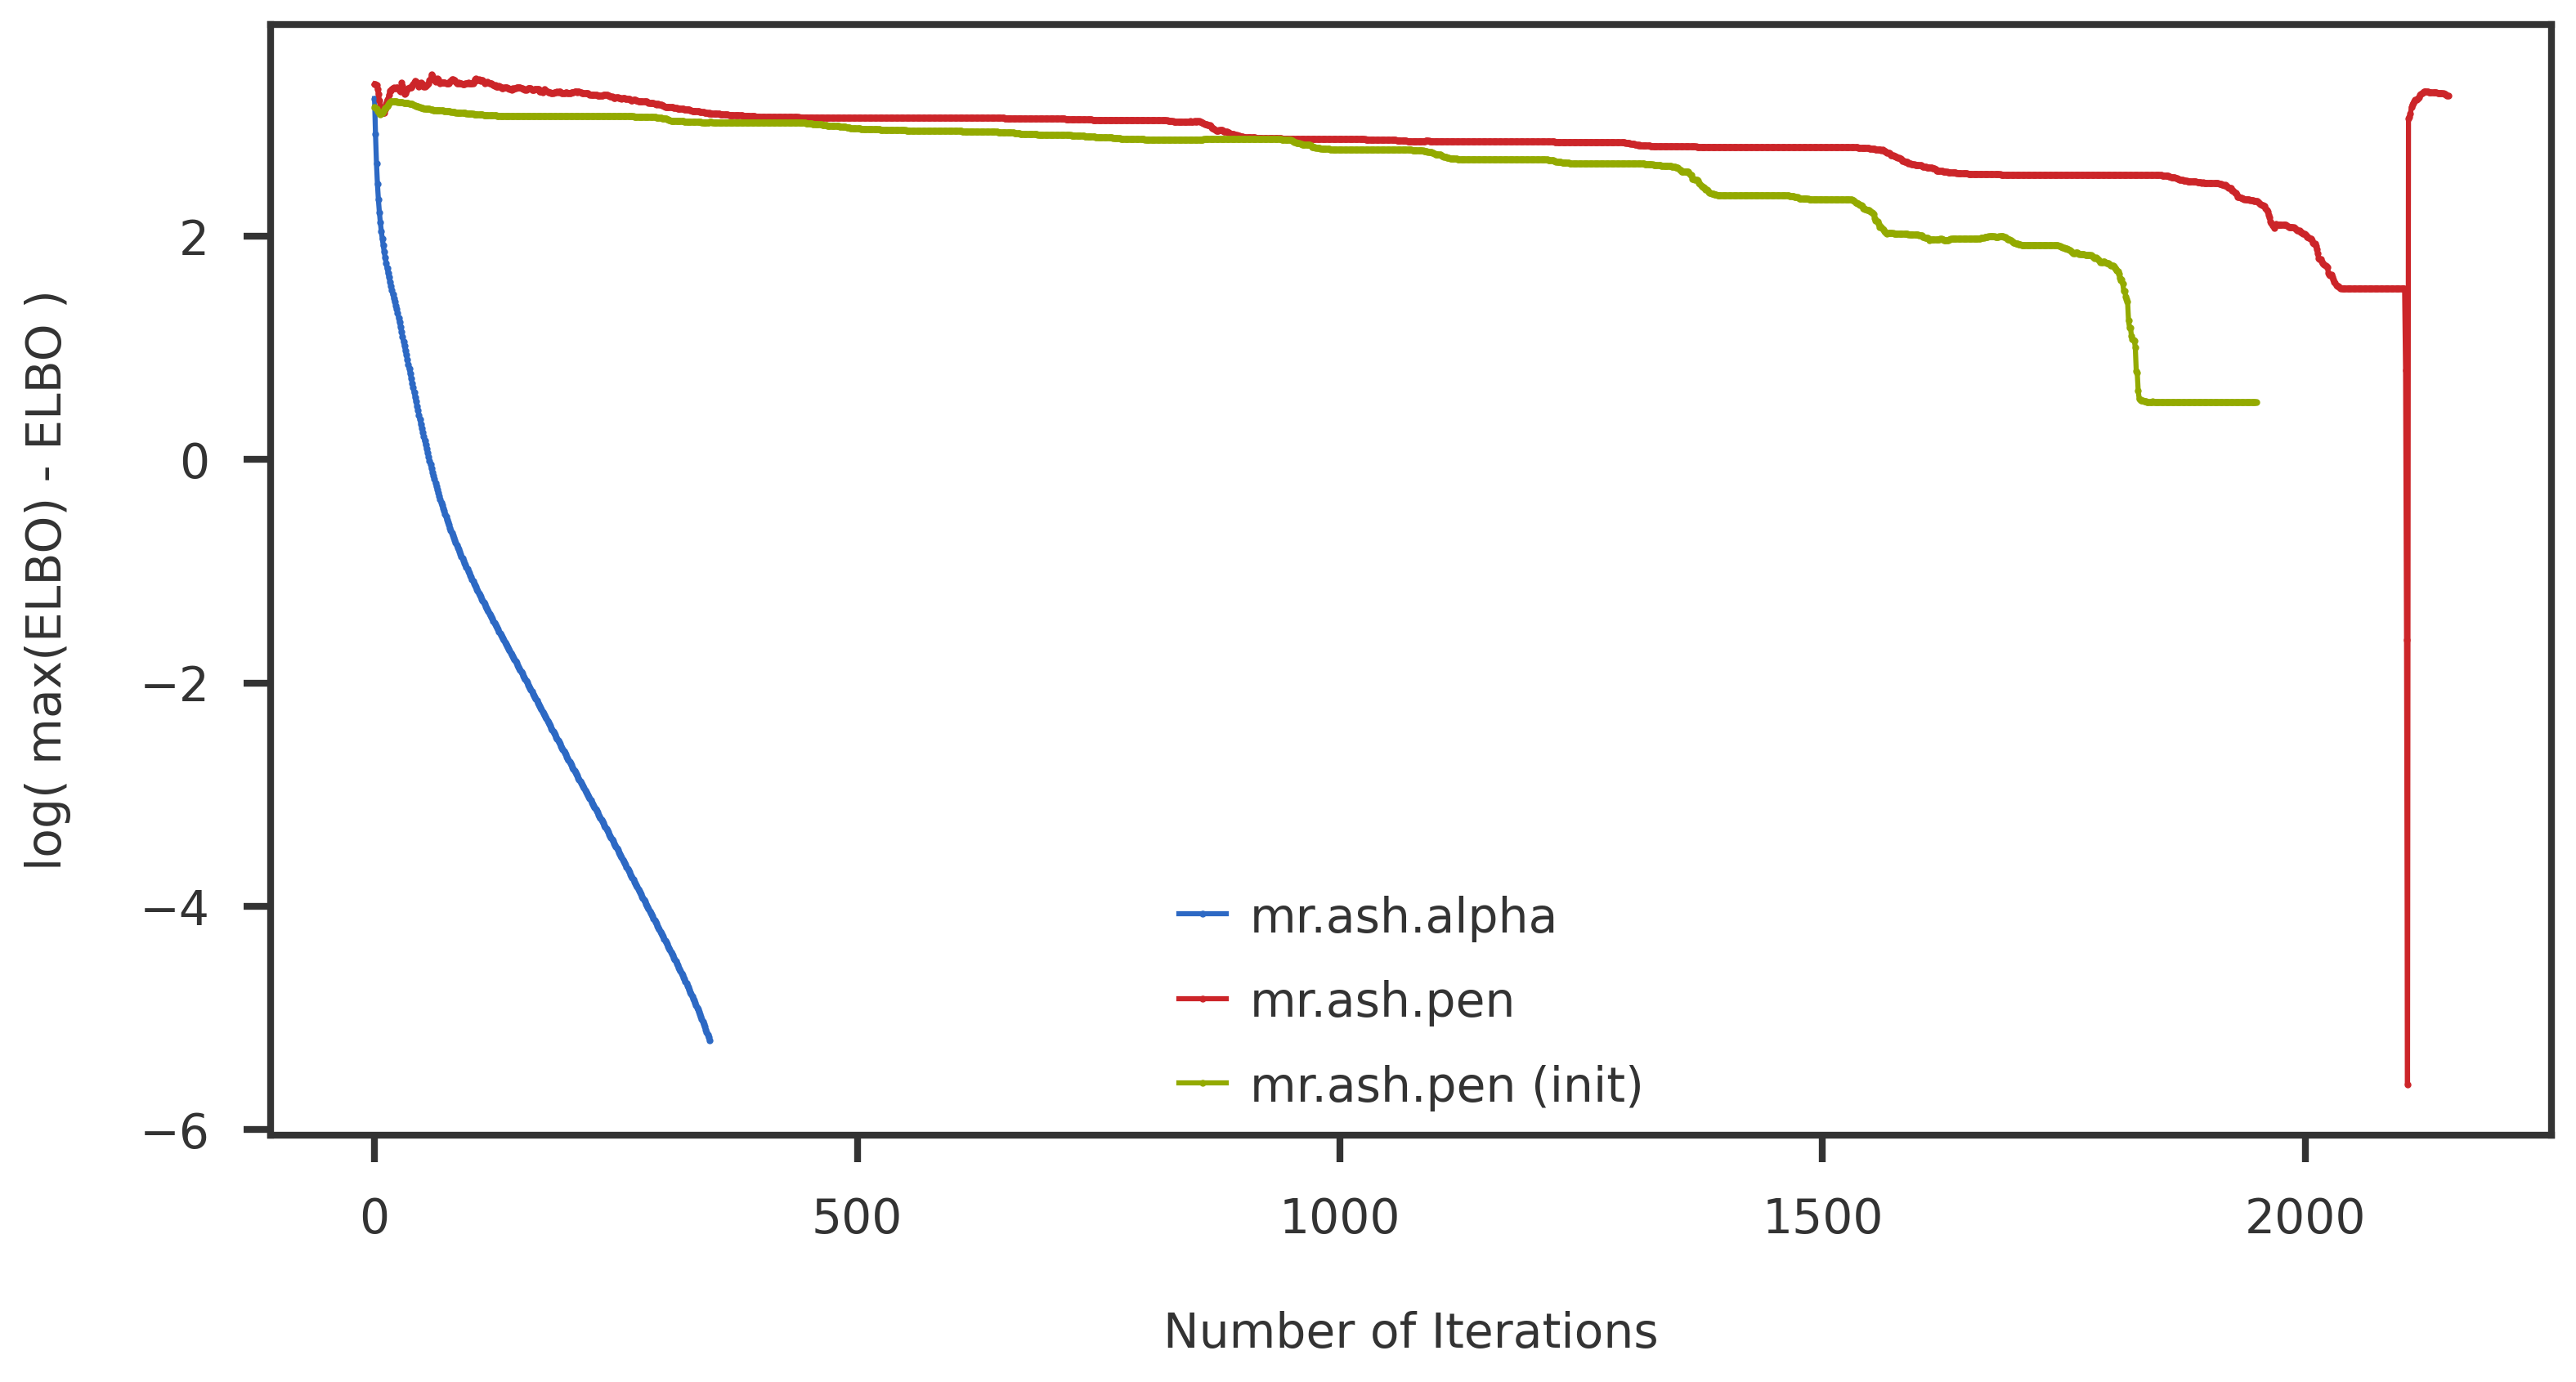

In [67]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.plr2.coef, intercept = plr_lbfgs.plr2.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_init.coef, intercept = plr_init.intercept, title = 'mr.ash.pen (init)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_init.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (init)"]
plot_convergence(objs, methods, kinit)